

# **Neural Networks Coursework Assignment**
# CandNo : 221455

**Brief of the assignment**

The main task of the assignment is to develop a deep neural network to perform multi-class (class num = 10) classification. Specifically, the dataset for this assignment is a CIFAR-10 image dataset. This deep neural network is implemented with an input layer, *three* hidden layers with Leaky ReLU nonlinear activation, and an output (classification) layer.

This neural network is implemented by the *Keras*. 

In this notebook contains:

* define CNN architecture for CIFAR-10 dataset
* train the dataset
* CIFAR-10 dataset contains 32x32 color images from 10 classes: **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck**

#0) ***Environment setup & Importing libraries***

* Setup the environment for Deep Learning and Machine Learning
* Useful Deep Learning Python Libraries:
> * Tensorflow: TensorFlow is an open source library for numerical computation using data flow graphs. Originally developed by the researchers on the Google Brain Team within Google’s Machine Intelligence research organization.
> * Keras: A minimalist, modular, Neural Network library, Keras uses Theano or TensorFlow as a backend. It makes it easy and faster to experiment and implement ideas into results.

## **0.1) Import the fundamental library (Use Keras)**


In [1]:
# Setup the environment for Deep Learning and Machine Learning 
import tensorflow as tf
from tensorflow import keras
import keras
from keras.datasets import cifar10
from keras import mixed_precision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Setup for designing the DNN structure
from keras.layers.convolutional import Conv
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, AveragePooling2D, Convolution2D
from keras.layers import LeakyReLU
from keras import optimizers, regularizers
from tensorflow.keras.utils import to_categorical, plot_model

%matplotlib inline

# 1) ***Load/Prepare the data set (Cifar 10)***

* The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms.
* The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes.
* The CIFAR-10 dataset is one of the most widely used datasets for machine learning research.
* The 10 different classes represent [*airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks*]. There are 6,000 images of each class.

## **1.1) Load the Cifar10 Dataset** 

A single train-val split is used here. The train data set is for the training process, the test set is for the evaluating process (Accuracy score & Loss score).

In [2]:
# fix the seed
np.random.seed(42)
tf.random.set_seed(42)

# Download and prepare the CIFAR10 dataset
# The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. 
# load the pre-shuffled train and test data from cifar10 (image files have the shape of (32, 32, 3))
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


* One-hot encoding : Convert class labels to binary class labels
> * Converting multiclass target column into multiple binary target columns for using in a Machine Learning Model
> * The classifier will be a multi-class classifier

In [3]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 10) 
# cifar10 : 10 classes, one_hot encoding
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 10) 
# cifar10 : 10 classes, one_hot encoding

## **1.2) Give the label name to each group of images**

In [4]:
# Verify the data
# The images from Cifar10 have labels (one label per image) from 10 classes
labels = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

**Visualize the 36 images from the Cifar10 data set.**

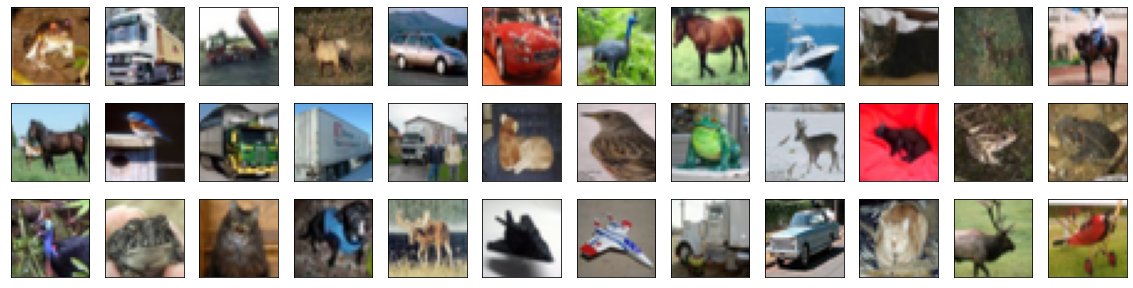

In [5]:
fig = plt.figure(figsize = (20, 5))
for i in range (36):
  ax = fig.add_subplot(3, 12, i + 1, xticks = [], yticks = [])
  ax.imshow(np.squeeze(x_train[i]))

**Confirm the shape of Cifar10 dataset.**

In [6]:
# Confirm the shape of the data set
print("Shape of x_train : ", x_train.shape)
print("Shape of y_train : ", y_train.shape)

print("Shape of x_test : ", x_test.shape)
print("Shape of y_test : ", y_test.shape)

Shape of x_train :  (50000, 32, 32, 3)
Shape of y_train :  (50000, 10)
Shape of x_test :  (10000, 32, 32, 3)
Shape of y_test :  (10000, 10)


## **1.3) Define the image preprocessing function (Normalize)**

* Convert image features to a 0-1 scale, from a 0-255 scale, by dividing with the maximum (255)
* Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network.

In [7]:
# define hyperparameter

batchSize = 32
imageSize = 32
imageShape = 32
AUTO = tf.data.AUTOTUNE

In [8]:
def data_normalize_and_resize(image, label):
  image = tf.image.resize(image, (imageShape, imageShape))
  # Rescale the images by dividing every pixel in every image by 255 (Normalization 0-1)
  image = tf.image.convert_image_dtype(image, tf.float32) / 255
  # rescale the images [0, 255] -> [0, 1]
  return image, label

**In this coursework, Cutmix data augmentation is used for preventing overfitting. So, the data is augmented by the following method.**

**Create the two types of train dataset:**


*   (normal) train dataset: train_normal
*   (cutmix) train dataset: train_data_set 


In [9]:
# Convert the data into TensorFlow Dataset objects

# Cutmix Augmentation function needs two images and labels pair for combining
# First pair
train_first_data_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024).map(data_normalize_and_resize, num_parallel_calls = AUTO)
# Second pair
train_second_data_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024).map(data_normalize_and_resize, num_parallel_calls = AUTO)

# No cutmix - normal data set for training and testing
train_normal = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_normal = (train_normal.map(data_normalize_and_resize, num_parallel_calls = AUTO).batch(batchSize).prefetch(AUTO))

# Cutmix - Combine two shuffled datasets from the same training data.
# Cutmix data (Data augmentation) set for training and testing
train_data_set = tf.data.Dataset.zip((train_first_data_set, train_second_data_set))
test_data_set = (test_data_set.map(data_normalize_and_resize, num_parallel_calls = AUTO).batch(batchSize).prefetch(AUTO))

## **1.4) Define the CutMix data augmentation function**

The CutMix function takes two images and labels pairs to perform the augmentation. It samples λ(l) from the Beta distribution and returns a bounding box from ***image_crop()*** function. Then crop the second image (image2) and pad this image in the final padded image at the same location.

In [10]:
# crop the part of the image
@tf.function
def image_crop(lambdaVal):
    cropSquare = tf.math.sqrt(1.0 - lambdaVal)

    cropWidth = imageShape * cropSquare  # rw
    cropWidth = tf.cast(cropWidth, tf.int32)

    cropHeight = imageShape * cropSquare  # rh
    cropHeight = tf.cast(cropHeight, tf.int32)

    cutX = tf.random.uniform((1,), minval = 0, maxval = imageShape, dtype = tf.int32)  # rx
    cutY = tf.random.uniform((1,), minval = 0, maxval = imageShape, dtype = tf.int32)  # ry

    boundaryX1 = tf.clip_by_value(cutX[0] - cropWidth // 2, 0, imageShape)
    boundaryY1 = tf.clip_by_value(cutY[0] - cropHeight // 2, 0, imageShape)
    bbx2 = tf.clip_by_value(cutX[0] + cropWidth // 2, 0, imageShape)
    bby2 = tf.clip_by_value(cutY[0] + cropHeight // 2, 0, imageShape)

    aimHeight = bby2 - boundaryY1
    if aimHeight == 0:
        aimHeight += 1

    aimWidth = bbx2 - boundaryX1
    if aimWidth == 0:
        aimWidth += 1

    return boundaryX1, boundaryY1, aimHeight, aimWidth

def distribution_beta(size, concentVal0 = 0.2, concentVal1 = 0.2):
    gammaVal1 = tf.random.gamma(shape = [size], alpha = concentVal1)
    gammaVal2 = tf.random.gamma(shape = [size], alpha = concentVal0)
    return gammaVal1 / (gammaVal1 + gammaVal2)

@tf.function    
def cutmix(train_first_data_set, train_second_data_set):

    (image1, label1), (image2, label2) = train_first_data_set, train_second_data_set

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambdaVal = distribution_beta(1, alpha, beta)
 
    # Define the Lambda value
    lambdaVal = lambdaVal[0][0]
  
    # Get the bounding box offsets, heights and widths
    boundaryX1, boundaryY1, aimHeight, aimWidth = image_crop(lambdaVal)

    # Get a crop from the second image (image2)
    crop2 = tf.image.crop_to_bounding_box(image2, boundaryY1, boundaryX1, aimHeight, aimWidth)
    # Pad the image2 crop (crop2) with the same offset
    image2 = tf.image.pad_to_bounding_box(crop2, boundaryY1, boundaryX1, imageShape, imageShape)
    # Get a crop from the first image (image1)
    crop1 = tf.image.crop_to_bounding_box(image1, boundaryY1, boundaryX1, aimHeight, aimWidth)
    # Pad the image1 crop (crop1) with the same offset
    img1 = tf.image.pad_to_bounding_box(crop1, boundaryY1, boundaryX1, imageShape, imageShape)

    # Modify the first image by subtracting the crop from image1
    # (before applying the image2 crop)
    image1 = image1 - img1
    # Add the modified image1 and image2  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambdaVal = 1 - (aimWidth * aimHeight) / (imageShape * imageShape)
    lambdaVal = tf.cast(lambdaVal, tf.float32)

    # Combine the labels of both images ; Mix the images
    label = lambdaVal * label1 + (1 - lambdaVal) * label2

    return image, label

**Note**: Combining two images to create a single one.

**Visualize the new dataset(train_data_set) after applying the CutMix augmentation**

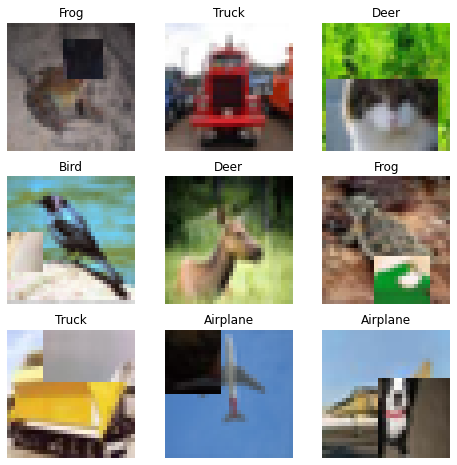

In [12]:
# Making the new dataset by the cutmix utility
train_data_cutMix = (train_data_set.shuffle(1024).map(cutmix, num_parallel_calls = AUTO).batch(batchSize).prefetch(AUTO))

# preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_data_cutMix))
plt.figure(figsize = (8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(labels[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis('off')

**Confirm the image mix with parts of the other image properly.**

In [ ]:
train_data_cutMix

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

# 2) ***Define the neural nerwork model***

Neural networks are built from several types of layers:

* **[Conv2D](https://keras.io/api/layers/convolution_layers/#conv2d)** - performs convolution
>  **Hyperparameters:**
> * **filters**: number of output channels;
> * **kernel_size**: an integer or tuple/list of 2 integers, specifying the width and height of the 2D convolution window;
> * **padding**: padding="same" adds zero padding to the input, so that the output has the same width and height, padding='valid' performs convolution only in locations where kernel and the input fully overlap;
> * **activation**: "Relu", "Leaky Relu", "tanh", etc.
> * **input_shape**: shape of input.
* **[MaxPooling2D](https://keras.io/api/layers/pooling_layers/#maxpooling2d)** - performs 2D max pooling.
* **[AveragePooling2D](https://keras.io/api/layers/pooling_layers/average_pooling2d/)** - performs 2D max pooling.
* **[Flatten](https://keras.io/api/layers/core_layers/#flatten)** - flattens the input, does not affect the batch size.
* **[Dense](https://keras.io/api/layers/core_layers/#dense)** - fully-connected layer.
* **[Activation](https://keras.io/api/layers/core_layers/#activation)** - applies an activation function.
* **[Dropout](https://keras.io/api/layers/core_layers/#dropout)** - applies dropout.

In this assignmnet, I should define a model which takes input_shape(None, 32, 32, 3) input and predicts (None, 10) output with probabilities for all classes (class num: 10). None in shapes stands for batch dimension.

**Used architecture of the Deep Neural Network:**

**Convolution Layer**
* A matrix of values, called weights, that are trained to detect specific features. Also called a filter, it moves over each part of the image to check if the feature it is meant to detect is present. To provide a value representing how confident it is that a specific feature is present, the filter carries out a convolution operation, which is an element-wise product and sum between two matrices.
* The output of the convolution operation between the filter and the input image is summed with a bias term and passed through a non-linear activation function. The purpose of the activation function is to introduce non-linearity into our network.
* ReLU stands for Rectified Linear Unit for a non-linear operation. The output is ƒ(x) = max(0,x).

**Max Pooling Layer**

* In max pooling, a window passes over an image according to a set stride (how many units to move on each pass). At each step, the maximum value within the window is pooled into an output matrix, hence the name max pooling.
* The result is a downsampled matrix of the image, that still contains the image's characteristics. This helps reduce overfitting and computational power required.

**Flattening Layer**

* Flattening involves transforming the entire pooled feature map matrix into a single long feature vector which is then fed to the neural network for processing.
* The rows are concatenated to form a single long row vector

**Fully connected Layer (Dense)**

* Neurons in a fully connected layer have full connections to all activations in the previous layer, as seen in regular Neural Networks.
* This is an efficient way of learning non-linear combinations of features extracted from previous convolutions
* Fully connected layer looks at the output of the previous layer (which as people remember should represent the activation maps of high level features) and determines which features most correlate to a particular class.
* For example, if the program is predicting that some image is a dog, it will have high values in the activation maps that represent high level features like a paw or 4 legs, etc. Similarly, if the program is predicting that some image is a bird, it will have high values in the activation maps that represent high level features like wings or a beak, etc. Basically, a FC layer looks at what high level features most strongly correlate to a particular class and has particular weights so that when you compute the products between the weights and the previous layer, you get the correct probabilities for the different classes.

## 2.1) **Define the model (Final version) with three hidden layers**

This is the ***final version*** of the structure with tuned hyperparameters of the DNN. The DNN consists of the input layer (Convolution layer), 3 hidden layers (Convolution layers), and the output layer(Dense layer).

All of the tuned hyperparameters in the network (***Width (Conv layer's filter number), Dropout, Depth, Convolutional filter size (kernel size), Batch size, Pooling, Activation Function, Learning Rate, Optimizer, number of epochs***) are had adjusted by some experiments which were written in the next several sections. 



In [ ]:
# image dimensions
input_shape = (32, 32, 3)

# used hyperparemeters
# section 4.5
kernel_size = 3
# section 4.6
batch_size = 16
# section 4.7
pool_size = 2
kernel_regularizer = regularizers.l2(0.01)
# section 4.4
dropout = 0.05
# section 4.9
learining_rate = 1e-3

In this task, I define a model which takes (None, 32, 32, 3) input and predicts (None, 10) output with probabilities for all classes. None in shapes stands for batch dimension.

In [ ]:
# Define the model

input_size = x_train.shape[1:]

# model is a 3-layer CNN with ReLU and dropout after each layer
model = Sequential()

# Input layer
model.add(Convolution2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1), 
                        input_shape = x_train.shape[1:]))
model.add(AveragePooling2D(pool_size = 2))
model.add(Dropout(0.05))

# 1st Hidden layer 
model.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
model.add(AveragePooling2D(pool_size = 2))
model.add(Dropout(0.05))
# 2nd Hidden layer 
model.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
model.add(AveragePooling2D(pool_size = 2))
model.add(Dropout(0.05))
# 3rd Hidden layer 
model.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
model.add(AveragePooling2D(pool_size = 2))
model.add(Dropout(0.05))

model.add(Flatten())
model.add(Dropout(0.05))

# Output layer
model.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

model.summary()

# The input image passes through the convolution layer, and the max-pooling layer and removes spatial information.
# The result is become to flatten, and then add two layers that are fully connected rather than locally connected.
# In the meantime, a dropout layer is added and minimizes over-fitting.
# This network uses only a much smaller number of parameters than MLP (MLP: 3,590,642 CNN: 528,054), but its ability to classify images is stronger.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 average_pooling2d_20 (Avera  (None, 16, 16, 64)       0         
 gePooling2D)                                                    
                                                                 
 dropout_25 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 average_pooling2d_21 (Avera  (None, 8, 8, 128)        0         
 gePooling2D)                                                    
                                                                 
 dropout_26 (Dropout)        (None, 8, 8, 128)        

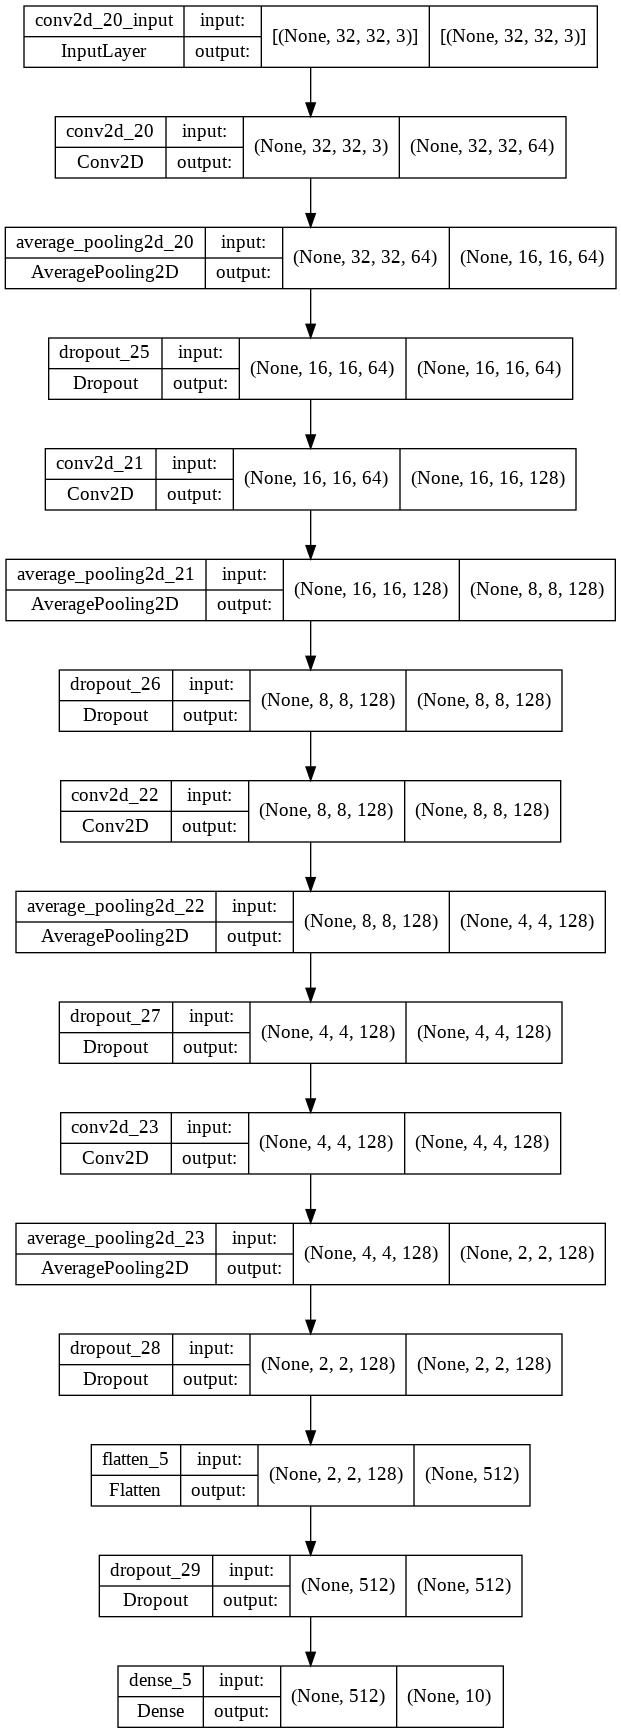

In [ ]:
plot_model(model, to_file = 'model-cnn.png', show_shapes = True)

In this study, I trained this model with 200 epochs in the ***section 6***. The result is following:

> **Test accuracy (optimizer: Adam / Epochs: 200): 84.34%**

> **Test loss (optimizer: Adam / Epochs: 200) : 52.43%**

#3) ***Explored the hyperparameters***

Each section use graphs (learning curves of train&validation performance; accuracy&loss) to show changing performance for different hyperparameter settings. 

In this coursework, one hyperparameter (each section title) is explored at a time by fixing all others to a reasonable arbitrary value. 

Compare the result performances of each setting and reflect the setting that shows the better result in the final version of DNN.

* 3.1-3.3) **Depth**
* 3.2) **Convolution layer's filter number**
* 3.3) **Use Batch Normalization / Do not use Batch Normalization**
* 3.4) **Dropout**
* 3.5) **Kernel size**
* 3.6) **Batch size**
* 3.7) **Pooling layer**
* 3.8) **Activation functions**
* 3.9) **Learning Rate**

In [ ]:
# start point of hyperparemeters 
# **not tuned yet**
# just put some default value arbitrarily for start point
kernel_size = 2
pool_size = 2
kernel_regularizer = regularizers.l2(0.01)
dropout = 0.2

## 3.1) **Training the data with different number of layers (Depth)**

### 3.1.1) **2 Hidden layer model**

* Input layer filter = 64
* 1st hidden layer filters = 128
* 2nd hidden layer filters = 128

In [ ]:
input_size = x_train.shape[1:]

# model is a 2-hidden layer CNN with ReLU and dropout after each layer
cnn2hidden = Sequential()

# Input layer
cnn2hidden.add(Convolution2D(filters = 64, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
cnn2hidden.add(MaxPooling2D(pool_size = 2))
cnn2hidden.add(Dropout(dropout))
# Hidden layer 1
cnn2hidden.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnn2hidden.add(MaxPooling2D(pool_size = 2))
cnn2hidden.add(Dropout(dropout))
# Hidden layer 2
cnn2hidden.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnn2hidden.add(MaxPooling2D(pool_size = 2))
cnn2hidden.add(Dropout(dropout))

cnn2hidden.add(Flatten())
cnn2hidden.add(Dropout(dropout))

# Output layer 
cnn2hidden.add(Dense(10, activation = 'softmax', kernel_regularizer=regularizers.l2(0.01)))

cnn2hidden.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 8, 8, 128)        

In [ ]:
cnn2hidden.save_weights("initial_weights.h5")

In [ ]:
cnn2hidden.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnn2hidden.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"]) 
cnnHist2 = cnn2hidden.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30)

test_loss, test_accuracy = cnn2hidden.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 46s 23ms/step - loss: 1.9429 - accuracy: 0.3459 - val_loss: 1.4153 - val_accuracy: 0.5309
Epoch 2/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.7276 - accuracy: 0.4631 - val_loss: 1.1990 - val_accuracy: 0.6033
Epoch 3/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.6582 - accuracy: 0.4994 - val_loss: 1.1226 - val_accuracy: 0.6488
Epoch 4/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.6142 - accuracy: 0.5205 - val_loss: 1.0573 - val_accuracy: 0.6790
Epoch 5/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.5817 - accuracy: 0.5348 - val_loss: 1.0208 - val_accuracy: 0.6833
Epoch 6/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5660 - accuracy: 0.5423 - val_loss: 1.0043 - val_accuracy: 0.6921
Epoch 7/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.5445 - accuracy: 0.5576 - val_loss: 0.9443 -

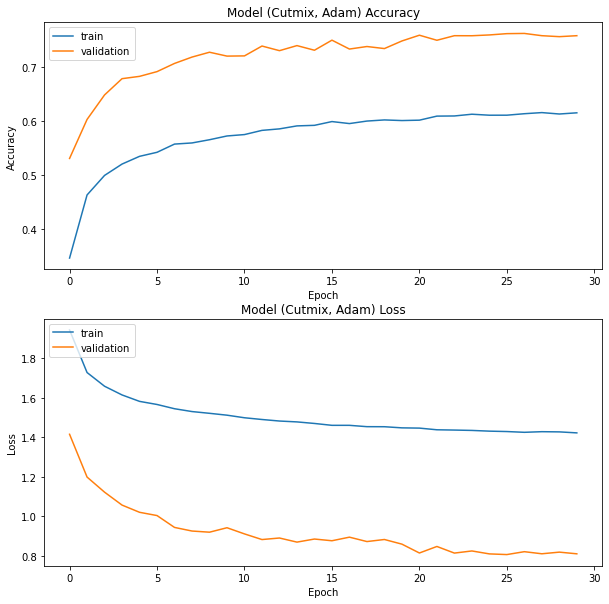

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHist2.history['accuracy'])  
plt.plot(cnnHist2.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHist2.history['loss'])  
plt.plot(cnnHist2.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

## 3.2) **Convolution layer's Filter number**

### 3.2.1) **3 Hidden layer model 1**

* Input layer filter = 64
* 1st hidden layer filters = 128
* 2nd hidden layer filters = 128
* 3nd hidden layer filters = 128

In [ ]:
input_size = x_train.shape[1:]

# model is a 3-hidden layer CNN with ReLU and dropout after each layer
cnn3hidden = Sequential()
# Input layer
cnn3hidden.add(Convolution2D(filters = 64, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
cnn3hidden.add(MaxPooling2D(pool_size = 2))
cnn3hidden.add(Dropout(dropout))
# Hidden layer 1
cnn3hidden.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnn3hidden.add(MaxPooling2D(pool_size = 2))
cnn3hidden.add(Dropout(dropout))
# Hidden layer 2
cnn3hidden.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnn3hidden.add(MaxPooling2D(pool_size = 2))
cnn3hidden.add(Dropout(dropout))
# Hidden layer 3
cnn3hidden.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnn3hidden.add(MaxPooling2D(pool_size = 2))
cnn3hidden.add(Dropout(dropout))

cnn3hidden.add(Flatten())
cnn3hidden.add(Dropout(dropout))

# Oupout layer
cnn3hidden.add(Dense(10, activation = 'softmax', kernel_regularizer=regularizers.l2(0.01)))

cnn3hidden.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        832       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)       131200    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 8, 8, 128)        

In [ ]:
cnn3hidden.save_weights("initial_weights.h5")

In [ ]:
cnn3hidden.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnn3hidden.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
cnnHist3 = cnn3hidden.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30)

test_loss, test_accuracy = cnn3hidden.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time))

Epoch 1/30
1563/1563 [==============================] - 40s 24ms/step - loss: 1.9598 - accuracy: 0.3211 - val_loss: 1.4103 - val_accuracy: 0.5081
Epoch 2/30
1563/1563 [==============================] - 37s 23ms/step - loss: 1.7320 - accuracy: 0.4384 - val_loss: 1.1483 - val_accuracy: 0.5941
Epoch 3/30
1563/1563 [==============================] - 37s 24ms/step - loss: 1.6429 - accuracy: 0.4874 - val_loss: 1.0963 - val_accuracy: 0.6435
Epoch 4/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5912 - accuracy: 0.5137 - val_loss: 1.0592 - val_accuracy: 0.6707
Epoch 5/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5533 - accuracy: 0.5342 - val_loss: 0.9581 - val_accuracy: 0.6851
Epoch 6/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5273 - accuracy: 0.5472 - val_loss: 0.9286 - val_accuracy: 0.6968
Epoch 7/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5050 - accuracy: 0.5548 - val_loss: 0.8962 -

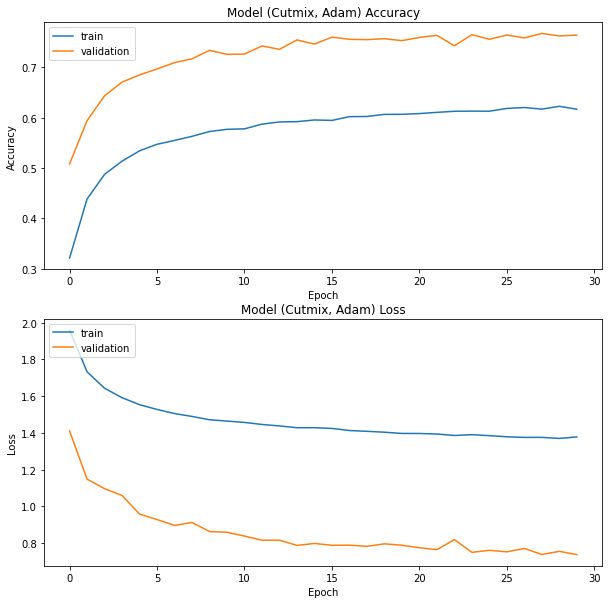

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHist3.history['accuracy'])  
plt.plot(cnnHist3.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHist3.history['loss'])  
plt.plot(cnnHist3.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

### 3.2.2) **3 Hidden layer model 2**

* Input layer filter = 32
* 1st hidden layer filters = 64
* 2nd hidden layer filters = 128
* 3nd hidden layer filters = 128


In [ ]:
input_size = x_train.shape[1:]

# model is a 3-layer CNN with ReLU and dropout after each layer
cnn3hidden1 = Sequential()
# Input layer
cnn3hidden1.add(Convolution2D(filters = 32, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
cnn3hidden1.add(MaxPooling2D(pool_size = 2))
cnn3hidden1.add(Dropout(dropout))
# Hidden layer 1
cnn3hidden1.add(Convolution2D(filters = 64, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnn3hidden1.add(MaxPooling2D(pool_size = 2))
cnn3hidden1.add(Dropout(dropout))
# Hidden layer 2
cnn3hidden1.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnn3hidden1.add(MaxPooling2D(pool_size = 2))
cnn3hidden1.add(Dropout(dropout))
# Hidden layer 3
cnn3hidden1.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnn3hidden1.add(MaxPooling2D(pool_size = 2))
cnn3hidden1.add(Dropout(dropout))

cnn3hidden1.add(Flatten())
cnn3hidden1.add(Dropout(dropout))
#cnn.add(Dense(hidden_units,activation='relu'))
#cnn.add(Dropout(dropout))
# Output layer
cnn3hidden1.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnn3hidden1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        416       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        32832     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 8, 8, 64)         

In [ ]:
cnn3hidden1.save_weights("initial_weights.h5")

In [ ]:
cnn3hidden1.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnn3hidden1.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"]) 
cnnHist3_1 = cnn3hidden1.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30)

test_loss, test_accuracy = cnn3hidden1.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 37s 23ms/step - loss: 1.9654 - accuracy: 0.3160 - val_loss: 1.3934 - val_accuracy: 0.5128
Epoch 2/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.7406 - accuracy: 0.4326 - val_loss: 1.2149 - val_accuracy: 0.5955
Epoch 3/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.6547 - accuracy: 0.4813 - val_loss: 1.1442 - val_accuracy: 0.6005
Epoch 4/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.6021 - accuracy: 0.5053 - val_loss: 1.0572 - val_accuracy: 0.6497
Epoch 5/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.5751 - accuracy: 0.5206 - val_loss: 0.9813 - val_accuracy: 0.6850
Epoch 6/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.5455 - accuracy: 0.5367 - val_loss: 0.9405 - val_accuracy: 0.6935
Epoch 7/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5262 - accuracy: 0.5451 - val_loss: 0.8937 -

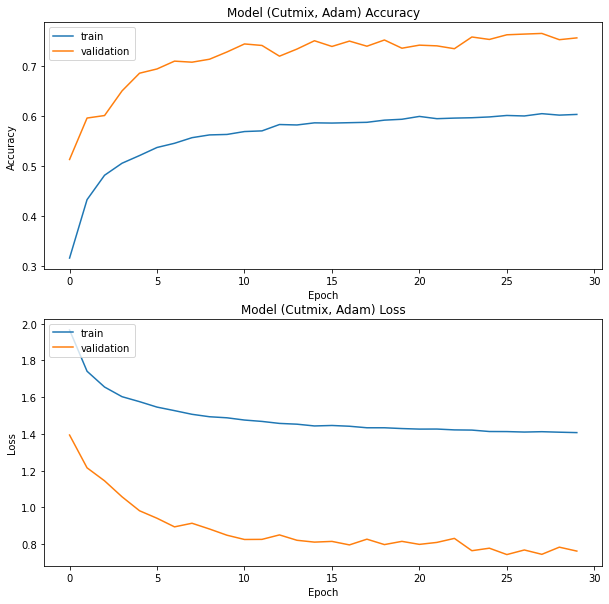

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHist3_1.history['accuracy'])  
plt.plot(cnnHist3_1.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHist3_1.history['loss'])  
plt.plot(cnnHist3_1.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

### 3.2.3) **3 Hidden layer model 3**

* Input layer filter = 32
* 1st hidden layer filters = 64
* 2nd hidden layer filters = 64
* 3nd hidden layer filters = 128

In [ ]:
# model is a 3-layer CNN with ReLU and dropout after each layer
cnn3hidden2 = Sequential()
# Input layer
cnn3hidden2.add(Convolution2D(filters = 32, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
cnn3hidden2.add(MaxPooling2D(pool_size = 2))
cnn3hidden2.add(Dropout(dropout))
# Hidden layer 1
cnn3hidden2.add(Convolution2D(filters = 64, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnn3hidden2.add(MaxPooling2D(pool_size = 2))
cnn3hidden2.add(Dropout(dropout))
# Hidden layer 2
cnn3hidden2.add(Convolution2D(filters = 64, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnn3hidden2.add(MaxPooling2D(pool_size = 2))
cnn3hidden2.add(Dropout(dropout))
# Hidden layer 3
cnn3hidden2.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnn3hidden2.add(MaxPooling2D(pool_size = 2))
cnn3hidden2.add(Dropout(dropout))

cnn3hidden2.add(Flatten())
cnn3hidden2.add(Dropout(dropout))
#cnn.add(Dense(hidden_units,activation='relu'))
#cnn.add(Dropout(dropout))
# Output layer
cnn3hidden2.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnn3hidden2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        416       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 64)        32832     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 8, 8, 64)         

In [ ]:
cnn3hidden2.save_weights("initial_weights.h5")

In [ ]:
cnn3hidden2.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnn3hidden2.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"]) 
cnnHist3_2 = cnn3hidden2.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30)

test_loss, test_accuracy = cnn3hidden2.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.9969 - accuracy: 0.3037 - val_loss: 1.4888 - val_accuracy: 0.4774
Epoch 2/30
1563/1563 [==============================] - 34s 22ms/step - loss: 1.7741 - accuracy: 0.4172 - val_loss: 1.2617 - val_accuracy: 0.5942
Epoch 3/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.6938 - accuracy: 0.4621 - val_loss: 1.1604 - val_accuracy: 0.6190
Epoch 4/30
1563/1563 [==============================] - 34s 22ms/step - loss: 1.6478 - accuracy: 0.4868 - val_loss: 1.1479 - val_accuracy: 0.6137
Epoch 5/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.6140 - accuracy: 0.5038 - val_loss: 1.0732 - val_accuracy: 0.6500
Epoch 6/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.5869 - accuracy: 0.5161 - val_loss: 1.0154 - val_accuracy: 0.6633
Epoch 7/30
1563/1563 [==============================] - 34s 22ms/step - loss: 1.5670 - accuracy: 0.5253 - val_loss: 0.9787 -

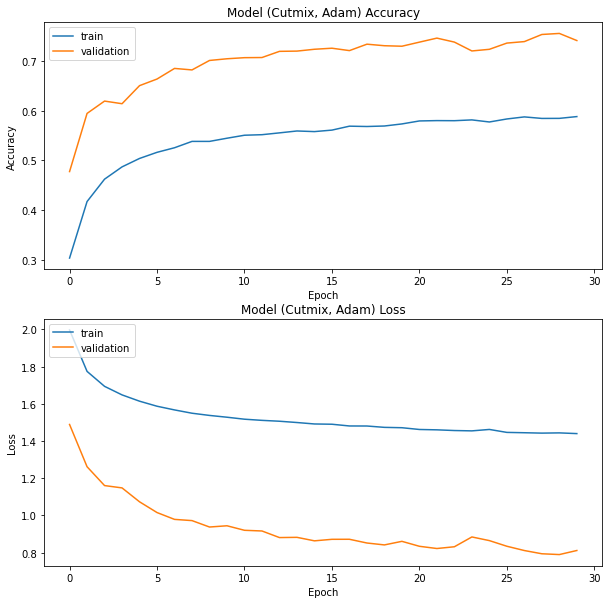

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHist3_2.history['accuracy'])  
plt.plot(cnnHist3_2.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHist3_2.history['loss'])  
plt.plot(cnnHist3_2.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

**Compare the performance of three DNN model (have different Conv layer filter numbers) with Acc/loss curve Graph**

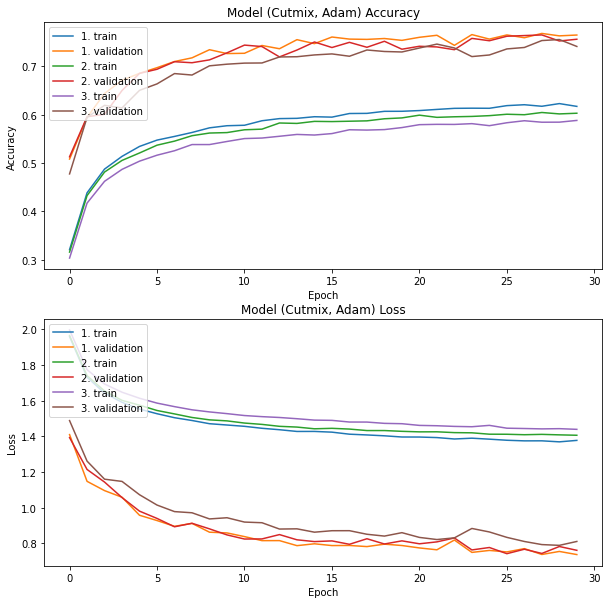

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHist3.history['accuracy'])  
plt.plot(cnnHist3.history['val_accuracy']) 
plt.plot(cnnHist3_1.history['accuracy'])  
plt.plot(cnnHist3_1.history['val_accuracy']) 
plt.plot(cnnHist3_2.history['accuracy'])  
plt.plot(cnnHist3_2.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['1. train', '1. validation', '2. train', '2. validation', '3. train', '3. validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHist3.history['loss'])  
plt.plot(cnnHist3.history['val_loss'])
plt.plot(cnnHist3_1.history['loss'])  
plt.plot(cnnHist3_1.history['val_loss'])
plt.plot(cnnHist3_2.history['loss'])  
plt.plot(cnnHist3_2.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['1. train', '1. validation', '2. train', '2. validation', '3. train', '3. validation'], loc = 'upper left')  
plt.show()

If I look at the graph above, I can confirm that the DNN performance is the best overall when the number of convolution filter is **(input: 64, hidden 1:128, hidden 2:128, hidden 3:128)**. Therefore, number of Conv filters (64, 128, 128, 128) are reflected in the final version of DNN.

DNN Setting  | Accuracy Score | Loss score
-------------------|--------------------|------------------
3 Hidden layer (filters: 64, 128, 128, 128) ★       | 76.42% | 73.79%
3 Hidden layer (filters: 32, 64, 128, 128)       | 75.55% | 76.18%
3 Hidden layer (filters: 32, 64, 64, 128)       | 74.06% | 81.14%

## 3.3) **Batch Normalization vs Without Batch Normalization**

### 3.3.1) **4 Hidden layer model 1 - BatchNormalization**

* Input layer filter = 64
* 1st hidden layer filters = 128
* 2nd hidden layer = BatchNormalization layer
* 3nd hidden layer filters = 128
* 4th hidden layer filters = 128

In [ ]:
from keras.layers import BatchNormalization

In [ ]:
input_size = x_train.shape[1:]

# model is a 4-layer CNN with ReLU and dropout after each layer
cnn4hidden = Sequential()
# Input layer
cnn4hidden.add(Convolution2D(filters = 64, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
cnn4hidden.add(MaxPooling2D(pool_size = 2))
cnn4hidden.add(Dropout(dropout))
# Hidden layer 1
cnn4hidden.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnn4hidden.add(MaxPooling2D(pool_size = 2))
cnn4hidden.add(Dropout(dropout))
# Hidden layer 2
cnn4hidden.add(BatchNormalization())
cnn4hidden.add(MaxPooling2D(pool_size = 2))
cnn4hidden.add(Dropout(dropout))
# Hidden layer 3
cnn4hidden.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnn4hidden.add(MaxPooling2D(pool_size = 2))
cnn4hidden.add(Dropout(dropout))
# Hidden layer 4
cnn4hidden.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnn4hidden.add(MaxPooling2D(pool_size = 2))
cnn4hidden.add(Dropout(dropout))

cnn4hidden.add(Flatten())
cnn4hidden.add(Dropout(dropout))
#cnn.add(Dense(hidden_units,activation='relu'))
#cnn.add(Dropout(dropout))
# Output layer
cnn4hidden.add(Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

cnn4hidden.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 64)        832       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 128)       131200    
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 8, 8, 128)        

In [ ]:
cnn4hidden.save_weights("initial_weights.h5")

In [ ]:
cnn4hidden.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnn4hidden.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"]) 
cnnHist4 = cnn4hidden.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30)

test_loss, test_accuracy = cnn4hidden.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 37s 23ms/step - loss: 1.9618 - accuracy: 0.3403 - val_loss: 1.5188 - val_accuracy: 0.4879
Epoch 2/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.7289 - accuracy: 0.4431 - val_loss: 1.2129 - val_accuracy: 0.5771
Epoch 3/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.6647 - accuracy: 0.4798 - val_loss: 1.1443 - val_accuracy: 0.6022
Epoch 4/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.6263 - accuracy: 0.4971 - val_loss: 1.5570 - val_accuracy: 0.4677
Epoch 5/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.5904 - accuracy: 0.5160 - val_loss: 1.1770 - val_accuracy: 0.5875
Epoch 6/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.5778 - accuracy: 0.5216 - val_loss: 1.0428 - val_accuracy: 0.6511
Epoch 7/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5617 - accuracy: 0.5289 - val_loss: 1.1649 -

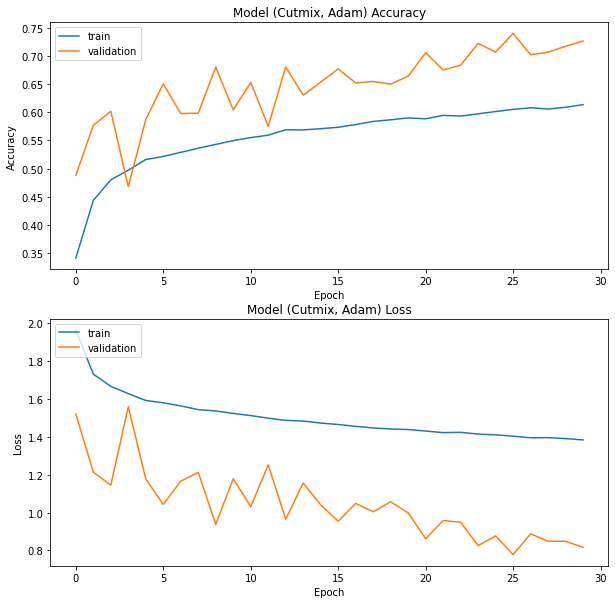

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHist4.history['accuracy'])  
plt.plot(cnnHist4.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHist4.history['loss'])  
plt.plot(cnnHist4.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

### 3.3.2) **4 Hidden layer model 2 - without BatchNormalization**

* Input layer filter = 64
* 1st hidden layer filters = 128
* 2nd hidden layer filters = 128
* 3nd hidden layer filters = 128
* 4th hidden layer filters = 128

In [ ]:
input_size = x_train.shape[1:]

# model is a 4-layer CNN with ReLU and dropout after each layer
cnn4hidden1 = Sequential()
# Input layer
cnn4hidden1.add(Convolution2D(filters = 64, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
cnn4hidden1.add(MaxPooling2D(pool_size = 2))
cnn4hidden1.add(Dropout(dropout))
# Hidden layer 1
cnn4hidden1.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnn4hidden1.add(MaxPooling2D(pool_size = 2))
cnn4hidden1.add(Dropout(dropout))
# Hidden layer 2
cnn4hidden1.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnn4hidden1.add(MaxPooling2D(pool_size = 2))
cnn4hidden1.add(Dropout(dropout))
# Hidden layer 3
cnn4hidden1.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnn4hidden1.add(MaxPooling2D(pool_size = 2))
cnn4hidden1.add(Dropout(dropout))
# Hidden layer 4
cnn4hidden1.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnn4hidden1.add(MaxPooling2D(pool_size = 2))
cnn4hidden1.add(Dropout(dropout))

cnn4hidden1.add(Flatten())
cnn4hidden1.add(Dropout(dropout))
#cnn.add(Dense(hidden_units,activation='relu'))
#cnn.add(Dropout(dropout))
# Output layer
cnn4hidden1.add(Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

cnn4hidden1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 32, 32, 64)        832       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_34 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 128)       131200    
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 dropout_35 (Dropout)        (None, 8, 8, 128)        

In [ ]:
cnn4hidden1.save_weights("initial_weights.h5")

In [ ]:
cnn4hidden1.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnn4hidden1.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
cnnHist4_1 = cnn4hidden1.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30)

test_loss, test_accuracy = cnn4hidden1.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 38s 24ms/step - loss: 1.9985 - accuracy: 0.2983 - val_loss: 1.3976 - val_accuracy: 0.5268
Epoch 2/30
1563/1563 [==============================] - 37s 24ms/step - loss: 1.7633 - accuracy: 0.4214 - val_loss: 1.2572 - val_accuracy: 0.5744
Epoch 3/30
1563/1563 [==============================] - 37s 24ms/step - loss: 1.6787 - accuracy: 0.4676 - val_loss: 1.1010 - val_accuracy: 0.6276
Epoch 4/30
1563/1563 [==============================] - 37s 24ms/step - loss: 1.6330 - accuracy: 0.4913 - val_loss: 1.0364 - val_accuracy: 0.6479
Epoch 5/30
1563/1563 [==============================] - 37s 24ms/step - loss: 1.6014 - accuracy: 0.5055 - val_loss: 0.9940 - val_accuracy: 0.6728
Epoch 6/30
1563/1563 [==============================] - 37s 24ms/step - loss: 1.5719 - accuracy: 0.5193 - val_loss: 0.9557 - val_accuracy: 0.6825
Epoch 7/30
1563/1563 [==============================] - 37s 23ms/step - loss: 1.5544 - accuracy: 0.5305 - val_loss: 0.9551 -

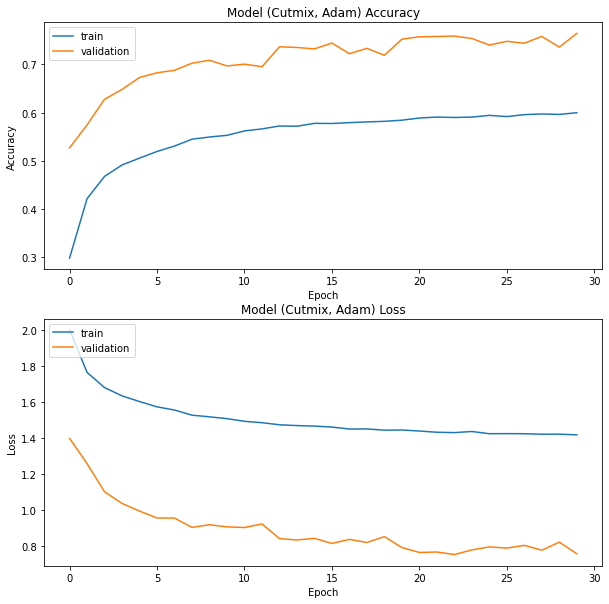

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHist4_1.history['accuracy'])  
plt.plot(cnnHist4_1.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHist4_1.history['loss'])  
plt.plot(cnnHist4_1.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

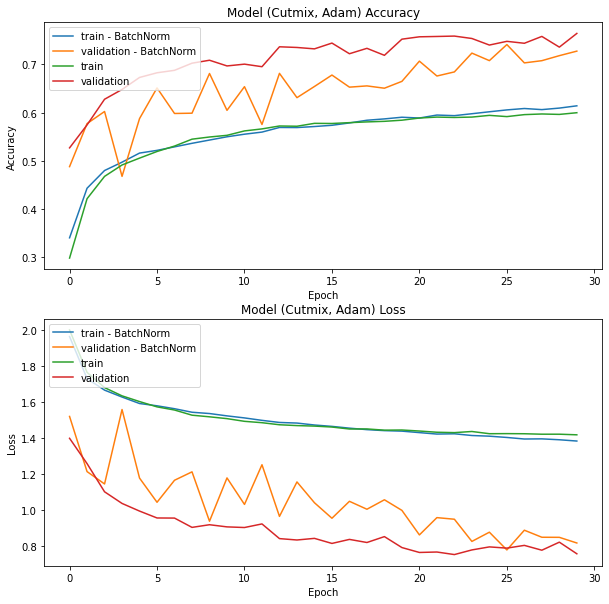

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHist4.history['accuracy'])  
plt.plot(cnnHist4.history['val_accuracy']) 
plt.plot(cnnHist4_1.history['accuracy'])  
plt.plot(cnnHist4_1.history['val_accuracy'])   
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train - BatchNorm', 'validation - BatchNorm', 'train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHist4.history['loss'])  
plt.plot(cnnHist4.history['val_loss'])
plt.plot(cnnHist4_1.history['loss'])  
plt.plot(cnnHist4_1.history['val_loss'])
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train - BatchNorm', 'validation - BatchNorm', 'train', 'validation'], loc = 'upper left')  
plt.show()

In this case, adding one more layer of convolution layer (4 hidden layer model with one more Conv model) with filters seemed more effective in maintaining accuracy than adding a BatchNormalization layer (4 hidden layer model with BatchNormalizaion layer). BatchNormalization() is a useful tool in DNN for preventing the overfitting, however, it should be used in the correct position and way to get better accuracy.

DNN Setting  | Accuracy Score | Loss score
-------------------|--------------------|------------------
4 Hidden layer (BatchNormalization)       | 72.74% | 81.69%
4 Hidden layer (Conv layer) ★       | 76.41% | 75.71%

**Compare the performance of DNN models (3 hidden layer vs 4 hidden layer) with Acc/loss curve Graph**

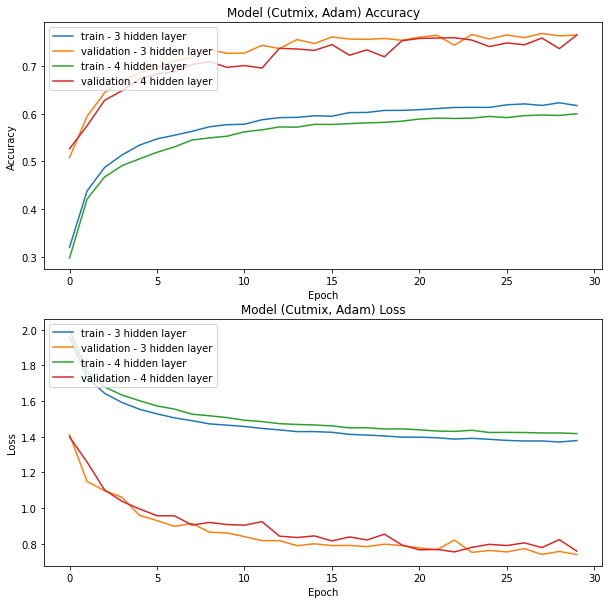

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHist3.history['accuracy'])  
plt.plot(cnnHist3.history['val_accuracy']) 
plt.plot(cnnHist4_1.history['accuracy'])  
plt.plot(cnnHist4_1.history['val_accuracy'])   
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train - 3 hidden layer', 'validation - 3 hidden layer', 'train - 4 hidden layer', 'validation - 4 hidden layer'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHist3.history['loss'])  
plt.plot(cnnHist3.history['val_loss'])
plt.plot(cnnHist4_1.history['loss'])  
plt.plot(cnnHist4_1.history['val_loss'])
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train - 3 hidden layer', 'validation - 3 hidden layer', 'train - 4 hidden layer', 'validation - 4 hidden layer'], loc = 'upper left')  
plt.show()

DNN Setting  | Accuracy Score | Loss score
-------------------|--------------------|------------------
2 Hidden layer (filters: 64, 128, 128)      | 75.88% | 81.09%
3 Hidden layer (filters: 64, 128, 128, 128) ★       | 76.42% | 73.79%
3 Hidden layer (filters: 32, 64, 128, 128)       | 75.55% | 76.18%
3 Hidden layer (filters: 32, 64, 64, 128)       | 74.06% | 81.14%
4 Hidden layer (BatchNormalization)       | 72.74% | 81.69%
4 Hidden layer (Conv layer) ★       | 76.41% | 75.71%

Comparing a model with two hidden layers and a model with three hidden layers, both the accuracy score and the loss score developed in a positive direction. On the other hand, comparing a model with three hidden layers and a model with four hidden layers, both the accuracy score and the loss score fell slightly in the negative direction. This means that just increasing the depth of the model cannot develop the accuracy score and loss score. Rather than just increasing the depth, it is more important to adjust the value of the hyperparameters suitable for the structure of each model. Also, there is a possibility available as the training parameter increases, the risk of overfitting also increases.

2 hidden layer (Total params: 414,794)
> Test accuracy: Test accuracy: 75.88%, Test loss: 81.09%, 1211.059412 sec.
* Input layer filter = 64
* 1st hidden layer filters = 128
* 2nd hidden layer filters = 128

3 hidden layer (Total params: 661,706)
> Test accuracy: Test accuracy: 76.42%, Test loss: 73.79%, 1211.059412 sec. 
* Input layer filter = 64
* 1st hidden layer filters = 128
* 2nd hidden layer filters = 128
* 3rd hidden layer filters = 128

4 hidden layer (Total params: 920,138)
> Test accuracy: 76.41%, Test loss: 75.71%, 1168.392398 sec sec.
* Input layer filter = 64
* 1st hidden layer filters = 128
* 2nd hidden layer filters = 128
* 3rd hidden layer filters = 128
* 4th hidden layer filters = 128




In addition, the case of 3 hidden layers of DNN with Conv filters**(64, 128, 128, 128)** shows the best accuracy and loss score. 

> ***Case reflected in the final DNN structure: Convolution filter (input: 64, hidden 1: 128, hidden 2: 128, hidden 3: 128)***

## 3.4) **Dropout vs Without Dropout**

### 3.4.1) **3 Hidden layer model - with Dropout (0.1)**

In [ ]:
input_size = x_train.shape[1:]
# model is a 3-layer CNN with ReLU and dropout after each layer
cnnD = Sequential()
# Input layer
cnnD.add(Convolution2D(filters = 64, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
cnnD.add(MaxPooling2D(pool_size = 2))
cnnD.add(Dropout(0.1))
# Hidden layer 1
cnnD.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnnD.add(MaxPooling2D(pool_size = 2))
cnnD.add(Dropout(0.1))
# Hidden layer 2
cnnD.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnnD.add(MaxPooling2D(pool_size = 2))
cnnD.add(Dropout(0.1))
# Hidden layer 3
cnnD.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnnD.add(MaxPooling2D(pool_size = 2))
cnnD.add(Dropout(0.1))

cnnD.add(Flatten())
cnnD.add(Dropout(0.1))

# Output layer
cnnD.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnnD.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 32, 32, 64)        832       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 128)       131200    
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 8, 8, 128)        

In [ ]:
cnnD.save_weights("initial_weights.h5")

In [ ]:
cnnD.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnnD.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"]) 
cnnHistD = cnnD.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30)

test_loss, test_accuracy = cnnD.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 37s 23ms/step - loss: 1.9181 - accuracy: 0.3429 - val_loss: 1.3898 - val_accuracy: 0.5345
Epoch 2/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.6687 - accuracy: 0.4712 - val_loss: 1.1158 - val_accuracy: 0.6344
Epoch 3/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5650 - accuracy: 0.5238 - val_loss: 0.9919 - val_accuracy: 0.6695
Epoch 4/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5173 - accuracy: 0.5459 - val_loss: 0.9185 - val_accuracy: 0.7046
Epoch 5/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.4774 - accuracy: 0.5677 - val_loss: 0.8811 - val_accuracy: 0.7096
Epoch 6/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.4496 - accuracy: 0.5803 - val_loss: 0.8331 - val_accuracy: 0.7257
Epoch 7/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.4302 - accuracy: 0.5918 - val_loss: 0.8604 -

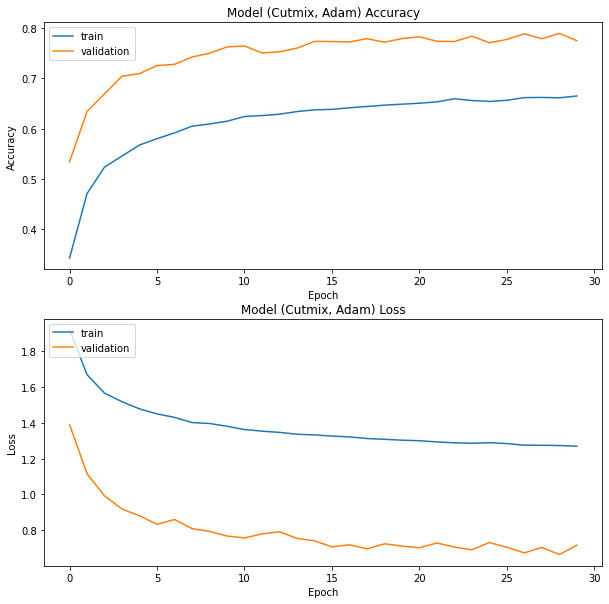

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHistD.history['accuracy'])  
plt.plot(cnnHistD.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHistD.history['loss'])  
plt.plot(cnnHistD.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

### 3.4.2) **3 Hidden layer model - with Dropout(0.05)**

In [ ]:
input_size = x_train.shape[1:]
# model is a 3-layer CNN with ReLU and dropout after each layer
cnnD5 = Sequential()
# Input layer
cnnD5.add(Convolution2D(filters = 64, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
cnnD5.add(MaxPooling2D(pool_size = 2))
cnnD5.add(Dropout(0.05))
# Hidden layer 1
cnnD5.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnnD5.add(MaxPooling2D(pool_size = 2))
cnnD5.add(Dropout(0.05))
# Hidden layer 2
cnnD5.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnnD5.add(MaxPooling2D(pool_size = 2))
cnnD5.add(Dropout(0.05))
# Hidden layer 3
cnnD5.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnnD5.add(MaxPooling2D(pool_size = 2))
cnnD5.add(Dropout(0.05))

cnnD5.add(Flatten())
cnnD5.add(Dropout(0.05))

# Output layer
cnnD5.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnnD5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 32, 32, 64)        832       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_45 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_36 (Conv2D)          (None, 16, 16, 128)       131200    
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 dropout_46 (Dropout)        (None, 8, 8, 128)        

In [ ]:
cnnD5.save_weights("initial_weights.h5")

In [ ]:
cnnD5.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnnD5.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"]) 
cnnHistD5 = cnnD5.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30)

test_loss, test_accuracy = cnnD5.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 38s 24ms/step - loss: 1.9072 - accuracy: 0.3455 - val_loss: 1.3258 - val_accuracy: 0.5456
Epoch 2/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.6736 - accuracy: 0.4652 - val_loss: 1.1504 - val_accuracy: 0.6175
Epoch 3/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5737 - accuracy: 0.5165 - val_loss: 1.0224 - val_accuracy: 0.6704
Epoch 4/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5128 - accuracy: 0.5507 - val_loss: 0.9602 - val_accuracy: 0.6878
Epoch 5/30
1563/1563 [==============================] - 37s 23ms/step - loss: 1.4743 - accuracy: 0.5685 - val_loss: 0.8975 - val_accuracy: 0.7076
Epoch 6/30
1563/1563 [==============================] - 37s 23ms/step - loss: 1.4475 - accuracy: 0.5798 - val_loss: 0.8628 - val_accuracy: 0.7310
Epoch 7/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.4117 - accuracy: 0.5983 - val_loss: 0.8853 -

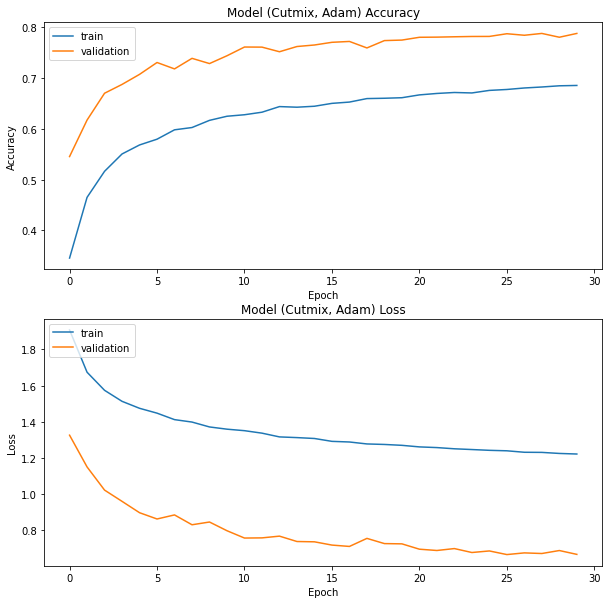

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHistD5.history['accuracy'])  
plt.plot(cnnHistD5.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHistD5.history['loss'])  
plt.plot(cnnHistD5.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

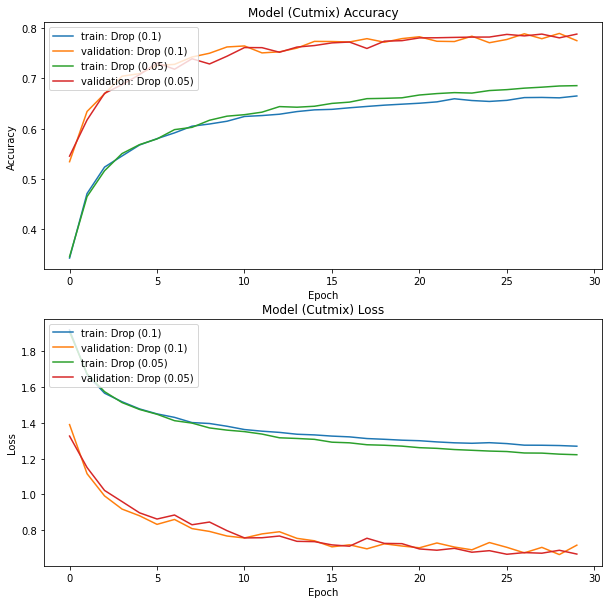

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)  
plt.plot(cnnHistD.history['accuracy'])  
plt.plot(cnnHistD.history['val_accuracy']) 
plt.plot(cnnHistD5.history['accuracy'])  
plt.plot(cnnHistD5.history['val_accuracy'])   
plt.title('Model (Cutmix) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train: Drop (0.1)', 'validation: Drop (0.1)',  'train: Drop (0.05)', 'validation: Drop (0.05)'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHistD.history['loss'])  
plt.plot(cnnHistD.history['val_loss']) 
plt.plot(cnnHistD5.history['loss'])  
plt.plot(cnnHistD5.history['val_loss'])
plt.title('Model (Cutmix) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train: Drop (0.1)', 'validation: Drop (0.1)', 'train: Drop (0.05)', 'validation: Drop (0.05)'], loc = 'upper left')  
plt.show()

Can see the output of DNN model with the **Dropout(0.05)** shows a bit better score than the DNN model with **Dropout(0.1)**. 

### 3.4.3) **3 Hidden layer model - without Dropout**

In [ ]:
input_size = x_train.shape[1:]

# model is a 3-layer CNN with ReLU and dropout after each layer
cnnNoneD = Sequential()
# Input layer
cnnNoneD.add(Convolution2D(filters = 64, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
cnnNoneD.add(MaxPooling2D(pool_size = 2))
# Hidden layer 1
cnnNoneD.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnnNoneD.add(MaxPooling2D(pool_size = 2))
# Hidden layer 2
cnnNoneD.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnnNoneD.add(MaxPooling2D(pool_size = 2))
# Hidden layer 3
cnnNoneD.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnnNoneD.add(MaxPooling2D(pool_size = 2))

cnnNoneD.add(Flatten())

# Output layer
cnnNoneD.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnnNoneD.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 32, 32, 64)        832       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 128)       131200    
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 8, 8, 128)         262272    
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 4, 4, 128)      

In [ ]:
cnnNoneD.save_weights("initial_weights.h5")

In [ ]:
cnnNoneD.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnnNoneD.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"]) 
cnnHistNoneD = cnnNoneD.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30)

test_loss, test_accuracy = cnnNoneD.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 37s 23ms/step - loss: 1.8743 - accuracy: 0.3671 - val_loss: 1.2572 - val_accuracy: 0.5756
Epoch 2/30
1563/1563 [==============================] - 37s 24ms/step - loss: 1.6110 - accuracy: 0.4980 - val_loss: 1.1238 - val_accuracy: 0.6263
Epoch 3/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5091 - accuracy: 0.5498 - val_loss: 0.9483 - val_accuracy: 0.6832
Epoch 4/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.4459 - accuracy: 0.5806 - val_loss: 0.8881 - val_accuracy: 0.7058
Epoch 5/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.4025 - accuracy: 0.5998 - val_loss: 0.8595 - val_accuracy: 0.7147
Epoch 6/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.3708 - accuracy: 0.6138 - val_loss: 0.8031 - val_accuracy: 0.7303
Epoch 7/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.3442 - accuracy: 0.6289 - val_loss: 0.7898 -

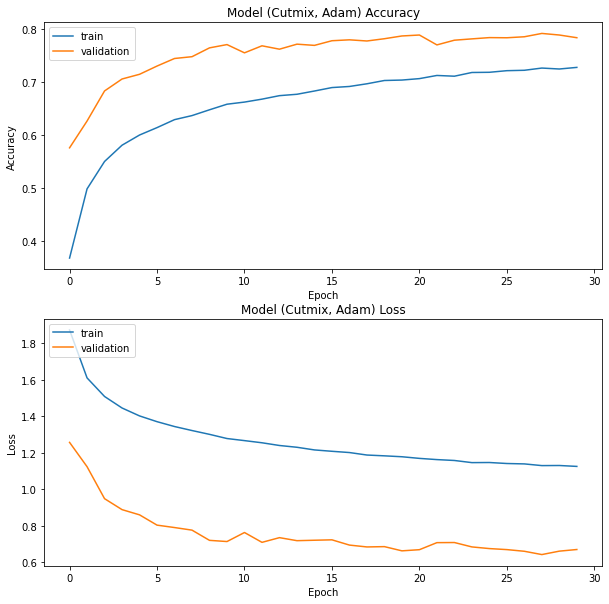

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHistNoneD.history['accuracy'])  
plt.plot(cnnHistNoneD.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHistNoneD.history['loss'])  
plt.plot(cnnHistNoneD.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

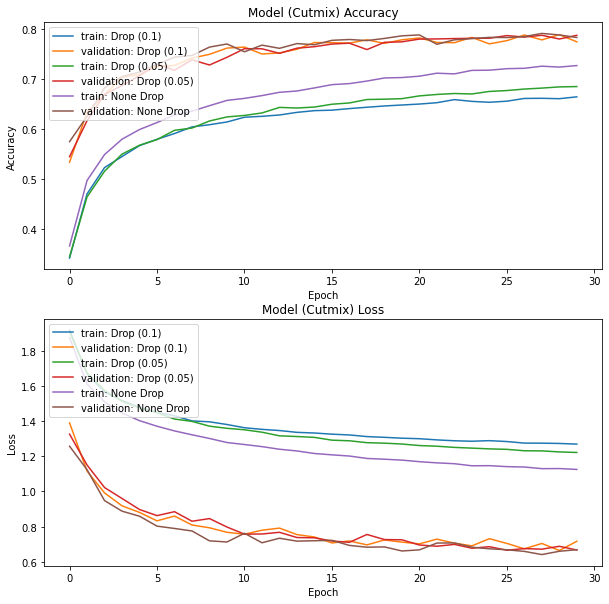

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)  
plt.plot(cnnHistD.history['accuracy'])  
plt.plot(cnnHistD.history['val_accuracy']) 
plt.plot(cnnHistD5.history['accuracy'])  
plt.plot(cnnHistD5.history['val_accuracy'])   
plt.plot(cnnHistNoneD.history['accuracy'])  
plt.plot(cnnHistNoneD.history['val_accuracy']) 
plt.title('Model (Cutmix) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train: Drop (0.1)', 'validation: Drop (0.1)',  'train: Drop (0.05)', 'validation: Drop (0.05)',
            'train: None Drop', 'validation: None Drop'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHistD.history['loss'])  
plt.plot(cnnHistD.history['val_loss']) 
plt.plot(cnnHistD5.history['loss'])  
plt.plot(cnnHistD5.history['val_loss'])
plt.plot(cnnHistNoneD.history['loss'])  
plt.plot(cnnHistNoneD.history['val_loss']) 
plt.title('Model (Cutmix) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train: Drop (0.1)', 'validation: Drop (0.1)', 'train: Drop (0.05)', 'validation: Drop (0.05)',
            'train: None Drop', 'validation: None Drop'], loc = 'upper left')  
plt.show()

DNN Setting  | Accuracy Score | Loss score
-------------------|--------------------|------------------
Dropout(0.2)       | 76.42% | 73.79%
Dropout(0.1)     | 77.52% | 71.70%
Dropout(0.05)★     | 78.83% | 66.73%
None Dropout       | 78.39% | 66.93%

The case of 3 hidden layers of DNN with **Dropout(0.05)** shows a better accuracy and loss score. Therefore, included **Dropout(0.05)** layers in the final version of the DNN structure.

> ***Case reflected in the final DNN structure: Dropout(0.05)***

## 3.5) **Kerner size: 2 vs 3 vs 4**

### 3.5.1) **3 Hidden layer model - Kernel: 2**

In [ ]:
input_size = x_train.shape[1:]
dropout = 0.05 # reflect the section 3.4 result (DNN with Dropout(0.05) shows a better accuracy and loss score)

# model is a 3-layer CNN with ReLU and dropout after each layer
cnnK2 = Sequential()
# Input layer
cnnK2.add(Convolution2D(filters = 64, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
cnnK2.add(MaxPooling2D(pool_size = 2))
cnnK2.add(Dropout(dropout))
# Hidden layer 1
cnnK2.add(Convolution2D(filters = 128, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu'))
cnnK2.add(MaxPooling2D(pool_size = 2))
cnnK2.add(Dropout(dropout))
# Hidden layer 2
cnnK2.add(Convolution2D(filters = 128, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu'))
cnnK2.add(MaxPooling2D(pool_size = 2))
cnnK2.add(Dropout(dropout))
# Hidden layer 3
cnnK2.add(Convolution2D(filters = 128, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu'))
cnnK2.add(MaxPooling2D(pool_size = 2))
cnnK2.add(Dropout(dropout))

cnnK2.add(Flatten())
cnnK2.add(Dropout(dropout))

# Output layer
cnnK2.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnnK2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       32896     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0

In [ ]:
cnnK2.save_weights("initial_weights.h5")

In [ ]:
cnnK2.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnnK2.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"]) 
cnnHistK2 = cnnK2.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30)

test_loss, test_accuracy = cnnK2.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 43s 21ms/step - loss: 1.9792 - accuracy: 0.3159 - val_loss: 1.4518 - val_accuracy: 0.4948
Epoch 2/30
1563/1563 [==============================] - 32s 20ms/step - loss: 1.7614 - accuracy: 0.4247 - val_loss: 1.2934 - val_accuracy: 0.5535
Epoch 3/30
1563/1563 [==============================] - 43s 28ms/step - loss: 1.6744 - accuracy: 0.4721 - val_loss: 1.1900 - val_accuracy: 0.6092
Epoch 4/30
1563/1563 [==============================] - 37s 24ms/step - loss: 1.6186 - accuracy: 0.4998 - val_loss: 1.1511 - val_accuracy: 0.6387
Epoch 5/30
1563/1563 [==============================] - 32s 20ms/step - loss: 1.5687 - accuracy: 0.5275 - val_loss: 1.0539 - val_accuracy: 0.6507
Epoch 6/30
1563/1563 [==============================] - 30s 19ms/step - loss: 1.5338 - accuracy: 0.5387 - val_loss: 1.0351 - val_accuracy: 0.6684
Epoch 7/30
1563/1563 [==============================] - 32s 20ms/step - loss: 1.5025 - accuracy: 0.5576 - val_loss: 0.9536 -

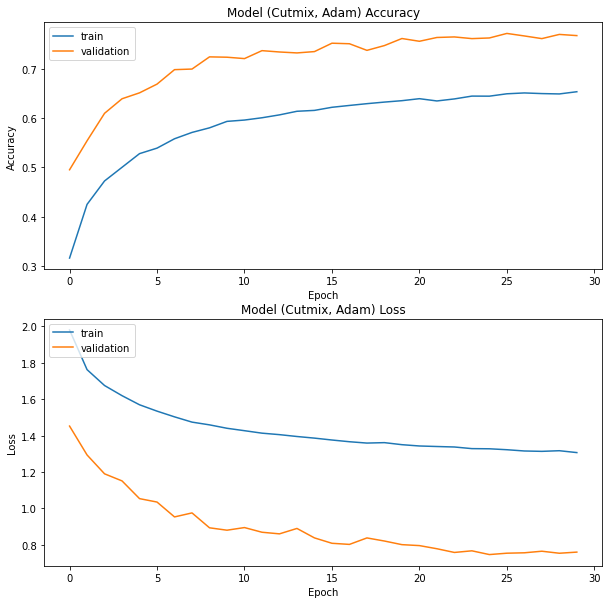

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHistK2.history['accuracy'])  
plt.plot(cnnHistK2.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHistK2.history['loss'])  
plt.plot(cnnHistK2.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

### 3.5.2) **3 Hidden layer model - Kernel: 3**

In [ ]:
input_size = x_train.shape[1:]
dropout = 0.05 # reflect the section 3.4 result (DNN with Dropout(0.05) shows a better accuracy and loss score)

# model is a 3-layer CNN with ReLU and dropout after each layer
cnnK3 = Sequential()
# Input layer
cnnK3.add(Convolution2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
cnnK3.add(MaxPooling2D(pool_size = 2))
cnnK3.add(Dropout(dropout))
# Hidden layer 1
cnnK3.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnnK3.add(MaxPooling2D(pool_size = 2))
cnnK3.add(Dropout(dropout))
# Hidden layer 2
cnnK3.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnnK3.add(MaxPooling2D(pool_size = 2))
cnnK3.add(Dropout(dropout))
# Hidden layer 3
cnnK3.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnnK3.add(MaxPooling2D(pool_size = 2))
cnnK3.add(Dropout(dropout))

cnnK3.add(Flatten())
cnnK3.add(Dropout(dropout))

# Output layer
cnnK3.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnnK3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 8, 8, 128)        

In [ ]:
cnnK3.save_weights("initial_weights.h5")

In [ ]:
cnnK3.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnnK3.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"]) 
cnnHistK3 = cnnK3.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30)

test_loss, test_accuracy = cnnK3.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.9085 - accuracy: 0.3480 - val_loss: 1.3428 - val_accuracy: 0.5470
Epoch 2/30
1563/1563 [==============================] - 32s 21ms/step - loss: 1.6576 - accuracy: 0.4795 - val_loss: 1.0575 - val_accuracy: 0.6500
Epoch 3/30
1563/1563 [==============================] - 33s 21ms/step - loss: 1.5548 - accuracy: 0.5331 - val_loss: 0.9839 - val_accuracy: 0.6925
Epoch 4/30
1563/1563 [==============================] - 32s 20ms/step - loss: 1.4877 - accuracy: 0.5652 - val_loss: 0.9154 - val_accuracy: 0.7050
Epoch 5/30
1563/1563 [==============================] - 32s 21ms/step - loss: 1.4472 - accuracy: 0.5834 - val_loss: 0.8806 - val_accuracy: 0.7305
Epoch 6/30
1563/1563 [==============================] - 32s 20ms/step - loss: 1.4184 - accuracy: 0.5980 - val_loss: 0.8238 - val_accuracy: 0.7415
Epoch 7/30
1563/1563 [==============================] - 33s 21ms/step - loss: 1.3909 - accuracy: 0.6118 - val_loss: 0.8045 -

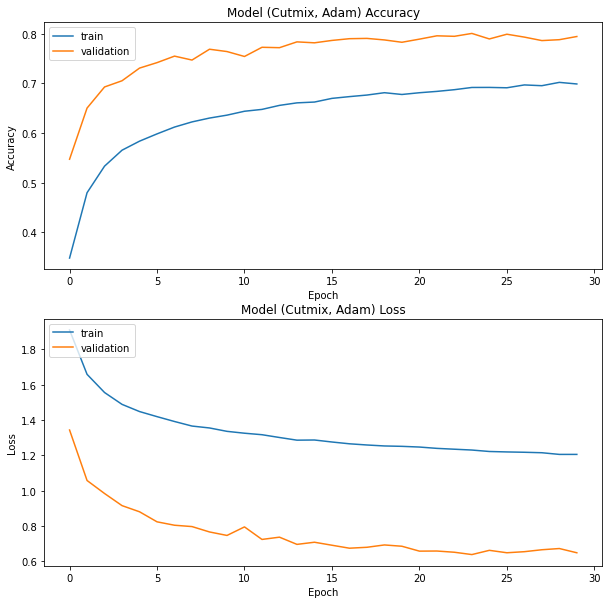

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHistK3.history['accuracy'])  
plt.plot(cnnHistK3.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHistK3.history['loss'])  
plt.plot(cnnHistK3.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

### 3.5.3) **3 Hidden layer model - Kernel: 4**

In [ ]:
dropout = 0.05 # reflect the section 3.4 result (DNN with Dropout(0.05) shows a better accuracy and loss score)
input_size = x_train.shape[1:]

# model is a 3-layer CNN with ReLU and dropout after each layer
cnnK4 = Sequential()
# Input layer
cnnK4.add(Convolution2D(filters = 64, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
cnnK4.add(MaxPooling2D(pool_size = 2))
cnnK4.add(Dropout(dropout))
# Hidden layer 1
cnnK4.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnnK4.add(MaxPooling2D(pool_size = 2))
cnnK4.add(Dropout(dropout))
# Hidden layer 2
cnnK4.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnnK4.add(MaxPooling2D(pool_size = 2))
cnnK4.add(Dropout(dropout))
# Hidden layer 3
cnnK4.add(Convolution2D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnnK4.add(MaxPooling2D(pool_size = 2))
cnnK4.add(Dropout(dropout))

cnnK4.add(Flatten())
cnnK4.add(Dropout(dropout))

# Output layer
cnnK4.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnnK4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 8, 8, 128)        

In [ ]:
cnnK4.save_weights("initial_weights.h5")

In [ ]:
cnnK4.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnnK4.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"]) 
cnnHistK4 = cnnK4.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30)

test_loss, test_accuracy = cnnK4.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 34s 21ms/step - loss: 1.9318 - accuracy: 0.3358 - val_loss: 1.3216 - val_accuracy: 0.5486
Epoch 2/30
1563/1563 [==============================] - 32s 21ms/step - loss: 1.6656 - accuracy: 0.4705 - val_loss: 1.1001 - val_accuracy: 0.6363
Epoch 3/30
1563/1563 [==============================] - 33s 21ms/step - loss: 1.5526 - accuracy: 0.5294 - val_loss: 0.9848 - val_accuracy: 0.6652
Epoch 4/30
1563/1563 [==============================] - 43s 27ms/step - loss: 1.4911 - accuracy: 0.5621 - val_loss: 0.8896 - val_accuracy: 0.7085
Epoch 5/30
1563/1563 [==============================] - 34s 21ms/step - loss: 1.4472 - accuracy: 0.5871 - val_loss: 0.8794 - val_accuracy: 0.7194
Epoch 6/30
1563/1563 [==============================] - 32s 20ms/step - loss: 1.4129 - accuracy: 0.5973 - val_loss: 0.8734 - val_accuracy: 0.7187
Epoch 7/30
1563/1563 [==============================] - 32s 21ms/step - loss: 1.3881 - accuracy: 0.6109 - val_loss: 0.7719 -

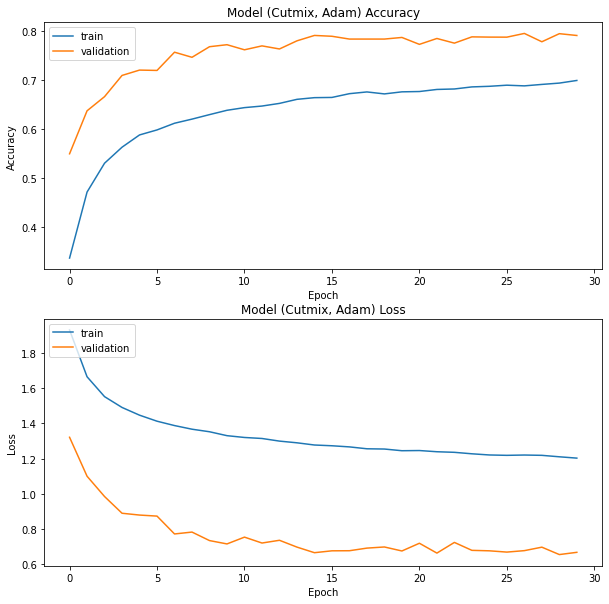

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHistK4.history['accuracy'])  
plt.plot(cnnHistK4.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHistK4.history['loss'])  
plt.plot(cnnHistK4.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

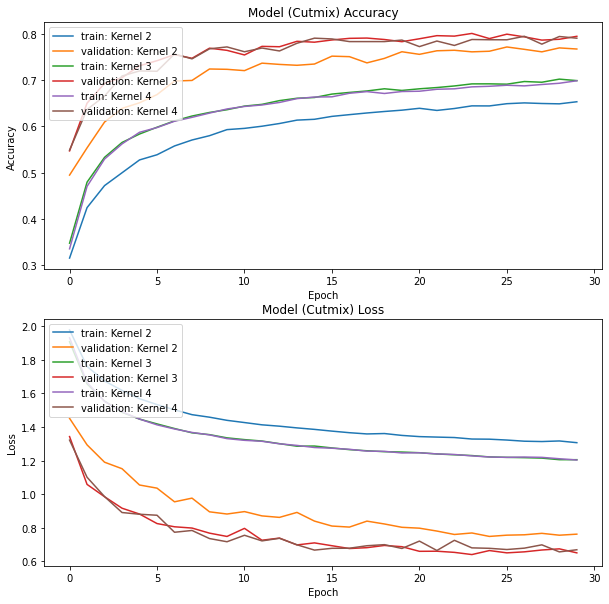

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)  
plt.plot(cnnHistK2.history['accuracy'])  
plt.plot(cnnHistK2.history['val_accuracy']) 
plt.plot(cnnHistK3.history['accuracy'])  
plt.plot(cnnHistK3.history['val_accuracy']) 
plt.plot(cnnHistK4.history['accuracy'])  
plt.plot(cnnHistK4.history['val_accuracy'])   
plt.title('Model (Cutmix) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train: Kernel 2', 'validation: Kernel 2', 'train: Kernel 3', 'validation: Kernel 3', 
            'train: Kernel 4', 'validation: Kernel 4'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)  
plt.plot(cnnHistK2.history['loss'])  
plt.plot(cnnHistK2.history['val_loss']) 
plt.plot(cnnHistK3.history['loss'])  
plt.plot(cnnHistK3.history['val_loss']) 
plt.plot(cnnHistK4.history['loss'])  
plt.plot(cnnHistK4.history['val_loss'])  
plt.title('Model (Cutmix) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train: Kernel 2', 'validation: Kernel 2', 'train: Kernel 3', 'validation: Kernel 3',
            'train: Kernel 4', 'validation: Kernel 4'], loc = 'upper left')  
plt.show()

DNN Setting  | Accuracy Score | Loss score
-------------------|--------------------|------------------
kernel_size = 2       | 76.67% | 76.05%
kernel_size = 3★     | 79.41%% | 64.89%
kernel_size = 4     | 79.00% | 66.75%

The case of 3 hidden layers of DNN with **Kernel_size(3)** shows a better accuracy and loss score. Therefore, included **Kernel_size(3)** layers in the final version of the DNN structure.

> ***Case reflected in the final DNN structure: Kerner_size = 3***

## 3.6) **Batch size: 64 vs 32 vs 16**

### 3.6.1) **3 Hidden layer model - Batch size: 64**

In [ ]:
input_size = x_train.shape[1:]
dropout = 0.05 # reflect the section 3.4 result (DNN with Dropout(0.05) shows a better accuracy and loss score)

# model is a 3-layer CNN with ReLU and dropout after each layer
cnn64 = Sequential()
# Input layer
cnn64.add(Convolution2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
cnn64.add(MaxPooling2D(pool_size = 2))
cnn64.add(Dropout(dropout))
# Hidden layer 1
cnn64.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnn64.add(MaxPooling2D(pool_size = 2))
cnn64.add(Dropout(dropout))
# Hidden layer 2
cnn64.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnn64.add(MaxPooling2D(pool_size = 2))
cnn64.add(Dropout(dropout))
# Hidden layer 3
cnn64.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnn64.add(MaxPooling2D(pool_size = 2))
cnn64.add(Dropout(dropout))

cnn64.add(Flatten())
cnn64.add(Dropout(dropout))

# Output layer
cnn64.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnn64.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 8, 8, 128)        

In [ ]:
cnn64.save_weights("initial_weights.h5")

In [ ]:
cnn64.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnn64.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
cnnHistB64 = cnn64.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30, batch_size = 64)

test_loss, test_accuracy = cnn64.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 47s 30ms/step - loss: 1.9237 - accuracy: 0.3434 - val_loss: 1.3877 - val_accuracy: 0.5285
Epoch 2/30
1563/1563 [==============================] - 46s 29ms/step - loss: 1.6795 - accuracy: 0.4657 - val_loss: 1.1029 - val_accuracy: 0.6411
Epoch 3/30
1563/1563 [==============================] - 46s 29ms/step - loss: 1.5695 - accuracy: 0.5225 - val_loss: 1.0384 - val_accuracy: 0.6734
Epoch 4/30
1563/1563 [==============================] - 42s 27ms/step - loss: 1.5046 - accuracy: 0.5592 - val_loss: 0.9192 - val_accuracy: 0.7090
Epoch 5/30
1563/1563 [==============================] - 33s 21ms/step - loss: 1.4615 - accuracy: 0.5795 - val_loss: 0.9020 - val_accuracy: 0.7146
Epoch 6/30
1563/1563 [==============================] - 45s 29ms/step - loss: 1.4252 - accuracy: 0.5958 - val_loss: 0.8501 - val_accuracy: 0.7231
Epoch 7/30
1563/1563 [==============================] - 41s 26ms/step - loss: 1.3990 - accuracy: 0.6082 - val_loss: 0.8375 -

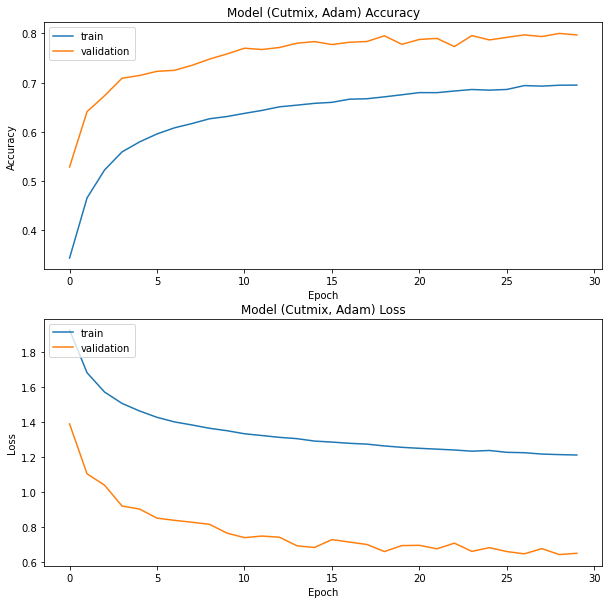

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHistB64.history['accuracy'])  
plt.plot(cnnHistB64.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHistB64.history['loss'])  
plt.plot(cnnHistB64.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

### 3.6.2) **3 Hidden layer model - Batch size: 32**

In [ ]:
input_size = x_train.shape[1:]
dropout = 0.05 # reflect the section 3.4 result (DNN with Dropout(0.05) shows a better accuracy and loss score)

# model is a 3-layer CNN with ReLU and dropout after each layer
cnn32 = Sequential()
# Input layer
cnn32.add(Convolution2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
cnn32.add(MaxPooling2D(pool_size = 2))
cnn32.add(Dropout(dropout))
# Hidden layer 1
cnn32.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnn32.add(MaxPooling2D(pool_size = 2))
cnn32.add(Dropout(dropout))
# Hidden layer 2
cnn32.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnn32.add(MaxPooling2D(pool_size = 2))
cnn32.add(Dropout(dropout))
# Hidden layer 3
cnn32.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnn32.add(MaxPooling2D(pool_size = 2))
cnn32.add(Dropout(dropout))

cnn32.add(Flatten())
cnn32.add(Dropout(dropout))

# Output layer
cnn32.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnn32.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 8, 8, 128)        

In [ ]:
cnn32.save_weights("initial_weights.h5")

In [ ]:
cnn32.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnn32.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
cnnHistB32 = cnn32.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30, batch_size = 32)

test_loss, test_accuracy = cnn32.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 33s 20ms/step - loss: 1.9165 - accuracy: 0.3441 - val_loss: 1.3635 - val_accuracy: 0.5297
Epoch 2/30
1563/1563 [==============================] - 32s 20ms/step - loss: 1.6655 - accuracy: 0.4712 - val_loss: 1.1031 - val_accuracy: 0.6381
Epoch 3/30
1563/1563 [==============================] - 32s 20ms/step - loss: 1.5602 - accuracy: 0.5287 - val_loss: 1.0091 - val_accuracy: 0.6835
Epoch 4/30
1563/1563 [==============================] - 32s 20ms/step - loss: 1.4999 - accuracy: 0.5600 - val_loss: 1.0203 - val_accuracy: 0.6703
Epoch 5/30
1563/1563 [==============================] - 32s 20ms/step - loss: 1.4471 - accuracy: 0.5855 - val_loss: 0.8742 - val_accuracy: 0.7248
Epoch 6/30
1563/1563 [==============================] - 31s 20ms/step - loss: 1.4188 - accuracy: 0.5983 - val_loss: 0.8332 - val_accuracy: 0.7351
Epoch 7/30
1563/1563 [==============================] - 32s 20ms/step - loss: 1.4002 - accuracy: 0.6057 - val_loss: 0.8533 -

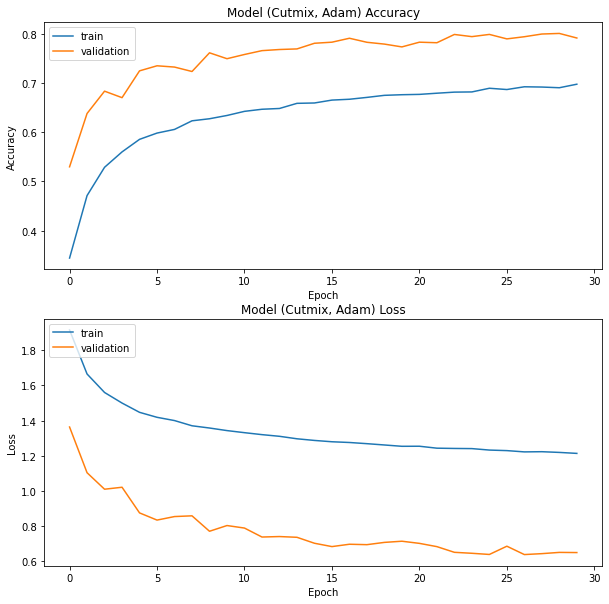

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHistB32.history['accuracy'])  
plt.plot(cnnHistB32.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHistB32.history['loss'])  
plt.plot(cnnHistB32.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

### 3.6.3) **3 Hidden layer model - Batch size: 16**

In [ ]:
input_size = x_train.shape[1:]
dropout = 0.05 # reflect the section 3.4 result (DNN with Dropout(0.05) shows a better accuracy and loss score)

# model is a 3-layer CNN with ReLU and dropout after each layer
cnn16 = Sequential()
# Input layer
cnn16.add(Convolution2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
cnn16.add(MaxPooling2D(pool_size = 2))
cnn16.add(Dropout(dropout))
# Hidden layer 1
cnn16.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnn16.add(MaxPooling2D(pool_size = 2))
cnn16.add(Dropout(dropout))
# Hidden layer 2
cnn16.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnn16.add(MaxPooling2D(pool_size = 2))
cnn16.add(Dropout(dropout))
# Hidden layer 3
cnn16.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnn16.add(MaxPooling2D(pool_size = 2))
cnn16.add(Dropout(dropout))

cnn16.add(Flatten())
cnn16.add(Dropout(dropout))

# Output layer
cnn16.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnn16.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 8, 8, 128)        

In [ ]:
cnn16.save_weights("initial_weights.h5")

In [ ]:
cnn16.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnn16.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
cnnHistB16 = cnn16.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30, batch_size = 16)

test_loss, test_accuracy = cnn16.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 33s 20ms/step - loss: 1.9000 - accuracy: 0.3525 - val_loss: 1.2787 - val_accuracy: 0.5795
Epoch 2/30
1563/1563 [==============================] - 32s 20ms/step - loss: 1.6474 - accuracy: 0.4820 - val_loss: 1.1125 - val_accuracy: 0.6506
Epoch 3/30
1563/1563 [==============================] - 32s 20ms/step - loss: 1.5383 - accuracy: 0.5406 - val_loss: 1.0427 - val_accuracy: 0.6755
Epoch 4/30
1563/1563 [==============================] - 32s 20ms/step - loss: 1.4808 - accuracy: 0.5687 - val_loss: 0.9014 - val_accuracy: 0.7100
Epoch 5/30
1563/1563 [==============================] - 31s 20ms/step - loss: 1.4420 - accuracy: 0.5866 - val_loss: 0.8610 - val_accuracy: 0.7260
Epoch 6/30
1563/1563 [==============================] - 32s 20ms/step - loss: 1.4140 - accuracy: 0.6002 - val_loss: 0.8065 - val_accuracy: 0.7470
Epoch 7/30
1563/1563 [==============================] - 31s 20ms/step - loss: 1.3907 - accuracy: 0.6143 - val_loss: 0.8164 -

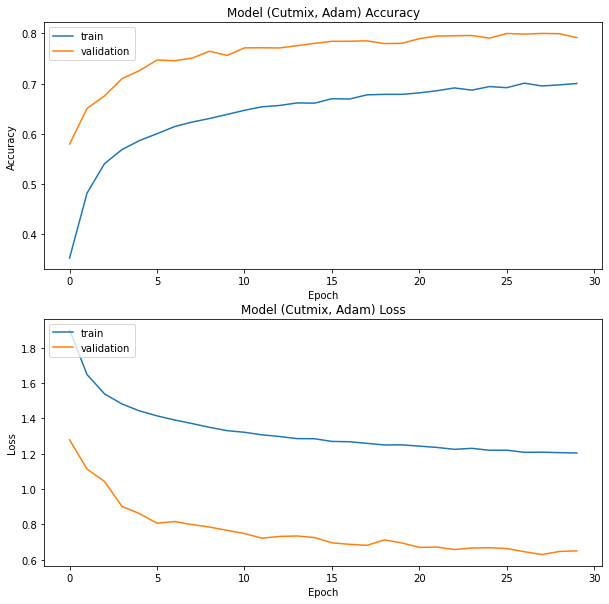

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHistB16.history['accuracy'])  
plt.plot(cnnHistB16.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHistB16.history['loss'])  
plt.plot(cnnHistB16.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

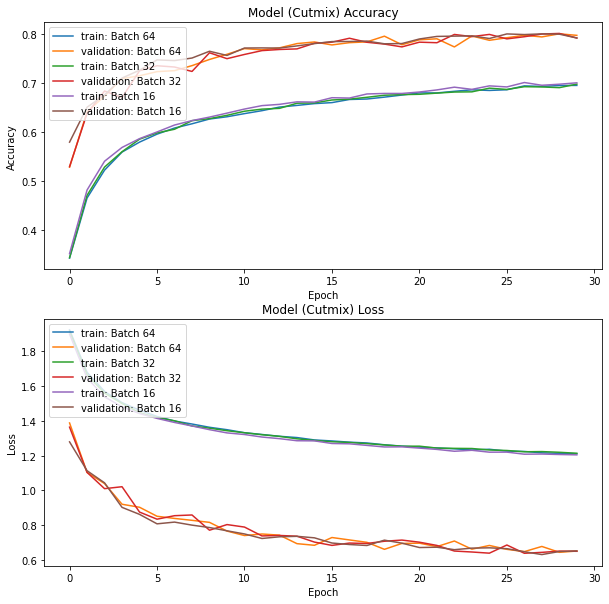

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)  
plt.plot(cnnHistB64.history['accuracy'])  
plt.plot(cnnHistB64.history['val_accuracy'])  
plt.plot(cnnHistB32.history['accuracy'])  
plt.plot(cnnHistB32.history['val_accuracy'])  
plt.plot(cnnHistB16.history['accuracy'])  
plt.plot(cnnHistB16.history['val_accuracy'])  
plt.title('Model (Cutmix) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train: Batch 64', 'validation: Batch 64', 'train: Batch 32', 'validation: Batch 32', 
            'train: Batch 16', 'validation: Batch 16'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)  
plt.plot(cnnHistB64.history['loss'])  
plt.plot(cnnHistB64.history['val_loss'])  
plt.plot(cnnHistB32.history['loss'])  
plt.plot(cnnHistB32.history['val_loss'])  
plt.plot(cnnHistB16.history['loss'])  
plt.plot(cnnHistB16.history['val_loss']) 
plt.title('Model (Cutmix) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train: Batch 64', 'validation: Batch 64', 'train: Batch 32', 'validation: Batch 32',
            'train: Batch 16', 'validation: Batch 16'], loc = 'upper left')  
plt.show()

DNN Setting  | Accuracy Score | Loss score | Training Time (Sec)
-------------------|--------------------|------------------|------------------
Batch_size = 64     | 79.70% | 64.96% | 1321.539496 sec
Batch_size = 32     | 79.16% | 64.82% | 1142.862516 sec
Batch_size = 16★   | 79.16% | 65.02% | 1096.323024 sec

The case of 3 hidden layers of DNN that has 64, 32, and 16 batch_size shows almost similar results of the output.  However, the training time shows a difference. So, I selected the batch_size = 16 since all three value shows similar output, but the 16 batch size DNN model shows the smallest training time.
Therefore, included `batch_size = 16` value in the final version of the DNN structure.

> ***Case reflected in the final DNN structure: Batch_Size = 16***

## 3.7) **Max pool vs Ave pool vs None** 

### 3.7.1) **With Max Pooling**

In [ ]:
input_size = x_train.shape[1:]
dropout = 0.05 # reflect the section 3.4 result (DNN with Dropout(0.05) shows a better accuracy and loss score)
# model is a 3-layer CNN with ReLU and dropout after each layer
cnnMP = Sequential()
# Input layer
cnnMP.add(Convolution2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
cnnMP.add(MaxPooling2D(pool_size = 2))
cnnMP.add(Dropout(dropout))
# Hidden layer 1
cnnMP.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnnMP.add(MaxPooling2D(pool_size = 2))
cnnMP.add(Dropout(dropout))
# Hidden layer 2
cnnMP.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnnMP.add(MaxPooling2D(pool_size = 2))
cnnMP.add(Dropout(dropout))
# Hidden layer 3
cnnMP.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnnMP.add(MaxPooling2D(pool_size = 2))
cnnMP.add(Dropout(dropout))

cnnMP.add(Flatten())
cnnMP.add(Dropout(dropout))

# Output layer
cnnMP.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnnMP.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0

In [ ]:
cnnMP.save_weights("initial_weights.h5")

In [ ]:
cnnMP.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnnMP.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"]) 
cnnHistMP = cnnMP.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30, batch_size = 16)
# reflect the section 3.6 result (DNN with Batch size: 16 shows a better accuracy and loss score)

test_loss, test_accuracy = cnnMP.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 47s 23ms/step - loss: 1.9162 - accuracy: 0.3488 - val_loss: 1.3321 - val_accuracy: 0.5552
Epoch 2/30
1563/1563 [==============================] - 38s 24ms/step - loss: 1.6520 - accuracy: 0.4828 - val_loss: 1.1178 - val_accuracy: 0.6281
Epoch 3/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5453 - accuracy: 0.5361 - val_loss: 1.0266 - val_accuracy: 0.6652
Epoch 4/30
1563/1563 [==============================] - 37s 23ms/step - loss: 1.4839 - accuracy: 0.5674 - val_loss: 0.9119 - val_accuracy: 0.7147
Epoch 5/30
1563/1563 [==============================] - 37s 24ms/step - loss: 1.4362 - accuracy: 0.5915 - val_loss: 0.8455 - val_accuracy: 0.7255
Epoch 6/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.4057 - accuracy: 0.6048 - val_loss: 0.8475 - val_accuracy: 0.7387
Epoch 7/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.3803 - accuracy: 0.6195 - val_loss: 0.8094 -

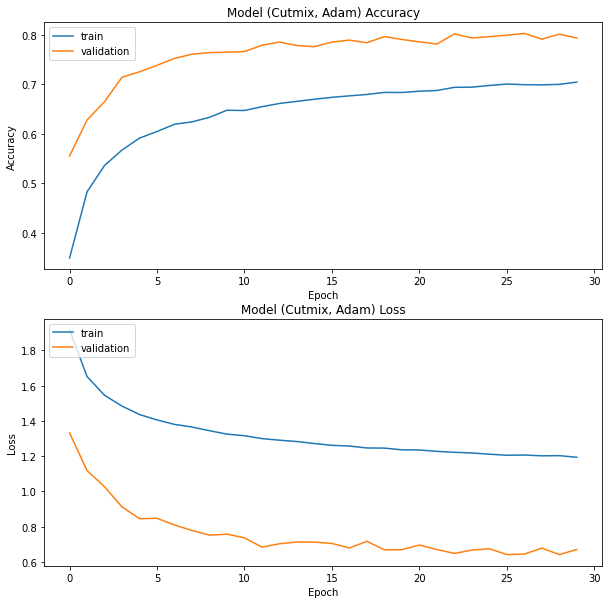

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHistMP.history['accuracy'])  
plt.plot(cnnHistMP.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHistMP.history['loss'])  
plt.plot(cnnHistMP.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

### 3.7.2) **Without Max Pooling**

In [ ]:
input_size = x_train.shape[1:]
dropout = 0.05 # reflect the section 3.4 result (DNN with Dropout(0.05) shows a better accuracy and loss score)
# model is a 3-layer CNN with ReLU and dropout after each layer
cnnNP = Sequential()
# Input layer
cnnNP.add(Convolution2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
cnnNP.add(Dropout(dropout))
# Hidden layer 1
cnnNP.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnnNP.add(Dropout(dropout))
# Hidden layer 2
cnnNP.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnnNP.add(Dropout(dropout))
# Hidden layer 3
cnnNP.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnnNP.add(Dropout(dropout))

cnnNP.add(Flatten())
cnnNP.add(Dropout(dropout))

# Output layer
cnnNP.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnnNP.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 dropout_6 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 dropout_7 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)      

In [ ]:
cnnNP.save_weights("initial_weights.h5")

In [ ]:
cnnNP.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnnNP.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"]) 
cnnHistNP = cnnNP.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30, batch_size = 16)
# reflect the section 3.6 result (DNN with Batch size: 16 shows a better accuracy and loss score)

test_loss, test_accuracy = cnnNP.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 73s 46ms/step - loss: 1.9976 - accuracy: 0.3373 - val_loss: 1.6135 - val_accuracy: 0.4741
Epoch 2/30
1563/1563 [==============================] - 71s 46ms/step - loss: 1.8598 - accuracy: 0.4284 - val_loss: 1.3957 - val_accuracy: 0.5638
Epoch 3/30
1563/1563 [==============================] - 71s 45ms/step - loss: 1.7892 - accuracy: 0.4877 - val_loss: 1.3669 - val_accuracy: 0.5946
Epoch 4/30
1563/1563 [==============================] - 71s 45ms/step - loss: 1.7642 - accuracy: 0.5268 - val_loss: 1.3548 - val_accuracy: 0.6232
Epoch 5/30
1563/1563 [==============================] - 71s 45ms/step - loss: 1.7735 - accuracy: 0.5506 - val_loss: 1.3071 - val_accuracy: 0.6491
Epoch 6/30
1563/1563 [==============================] - 71s 46ms/step - loss: 1.7896 - accuracy: 0.5647 - val_loss: 1.3037 - val_accuracy: 0.6839
Epoch 7/30
1563/1563 [==============================] - 71s 45ms/step - loss: 1.8030 - accuracy: 0.5750 - val_loss: 1.3125 -

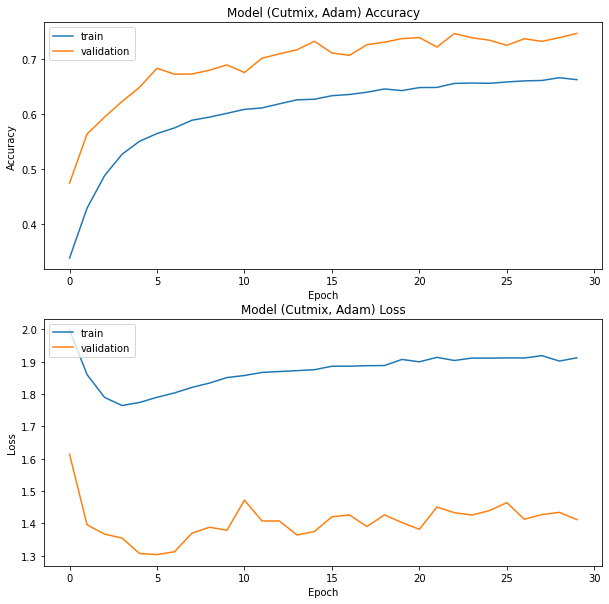

In [ ]:
# plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHistNP.history['accuracy'])  
plt.plot(cnnHistNP.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHistNP.history['loss'])  
plt.plot(cnnHistNP.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

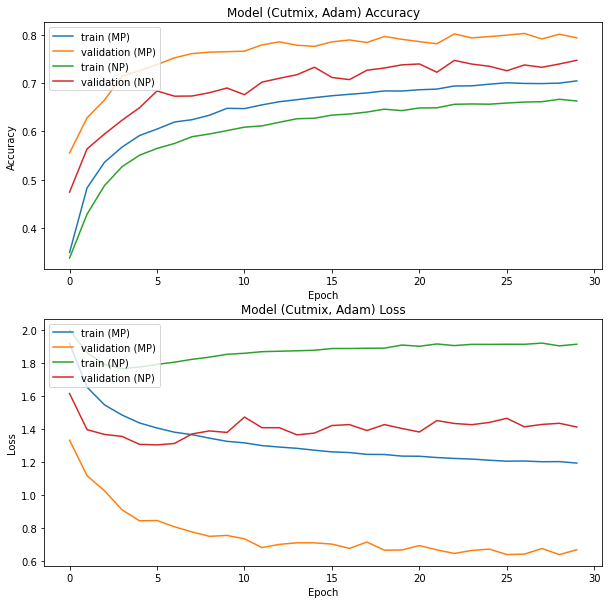

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHistMP.history['accuracy'])  
plt.plot(cnnHistMP.history['val_accuracy'])  
plt.plot(cnnHistNP.history['accuracy'])  
plt.plot(cnnHistNP.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train (MP)', 'validation (MP)', 'train (NP)', 'validation (NP)'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHistMP.history['loss'])  
plt.plot(cnnHistMP.history['val_loss']) 
plt.plot(cnnHistNP.history['loss'])  
plt.plot(cnnHistNP.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train (MP)', 'validation (MP)', 'train (NP)', 'validation (NP)'], loc = 'upper left')  
plt.show()

When comparing the output of the DNN model with max-pooling and without max pooling, especially the validation loss score shows a big difference. (overfitting occurs) The DNN with max-pooling shows the decreasing loss graph, however, the DNN model without a max-pooling layer shows just a loss graph that increasing. In addition, models with max-pooling layers are better for both accuracy and loss scores.

### 3.7.3) **With Average Pooling**

In [ ]:
from keras.layers import AveragePooling2D

In [ ]:
input_size = x_train.shape[1:]
dropout = 0.05 # reflect the section 3.4 result (DNN with Dropout(0.05) shows a better accuracy and loss score)
# model is a 3-layer CNN with ReLU and dropout after each layer
cnnAP = Sequential()
# Input layer
cnnAP.add(Convolution2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
cnnAP.add(AveragePooling2D(pool_size = 2))
cnnAP.add(Dropout(dropout))
# Hidden layer 1
cnnAP.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnnAP.add(AveragePooling2D(pool_size = 2))
cnnAP.add(Dropout(dropout))
# Hidden layer 2
cnnAP.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnnAP.add(AveragePooling2D(pool_size = 2))
cnnAP.add(Dropout(dropout))
# Hidden layer 3
cnnAP.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnnAP.add(AveragePooling2D(pool_size = 2))
cnnAP.add(Dropout(dropout))

cnnAP.add(Flatten())
cnnAP.add(Dropout(dropout))

# Output layer
cnnAP.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnnAP.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 64)       0         
 ooling2D)                                                       
                                                                 
 dropout_10 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 average_pooling2d_1 (Averag  (None, 8, 8, 128)        0         
 ePooling2D)                                                     
                                                                 
 dropout_11 (Dropout)        (None, 8, 8, 128)        

In [ ]:
cnnAP.save_weights("initial_weights.h5")

In [ ]:
cnnAP.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnnAP.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"]) 
cnnHistAP = cnnAP.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30, batch_size = 16)
# reflect the section 3.6 result (DNN with Batch size: 16 shows a better accuracy and loss score)

test_loss, test_accuracy = cnnAP.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 37s 23ms/step - loss: 1.9668 - accuracy: 0.3169 - val_loss: 1.5318 - val_accuracy: 0.4655
Epoch 2/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.7775 - accuracy: 0.4132 - val_loss: 1.3175 - val_accuracy: 0.5488
Epoch 3/30
1563/1563 [==============================] - 38s 24ms/step - loss: 1.6757 - accuracy: 0.4675 - val_loss: 1.1770 - val_accuracy: 0.5935
Epoch 4/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.6070 - accuracy: 0.5041 - val_loss: 1.0600 - val_accuracy: 0.6521
Epoch 5/30
1563/1563 [==============================] - 35s 23ms/step - loss: 1.5548 - accuracy: 0.5315 - val_loss: 0.9880 - val_accuracy: 0.6745
Epoch 6/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5197 - accuracy: 0.5469 - val_loss: 0.9855 - val_accuracy: 0.6772
Epoch 7/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.4846 - accuracy: 0.5658 - val_loss: 0.9103 -

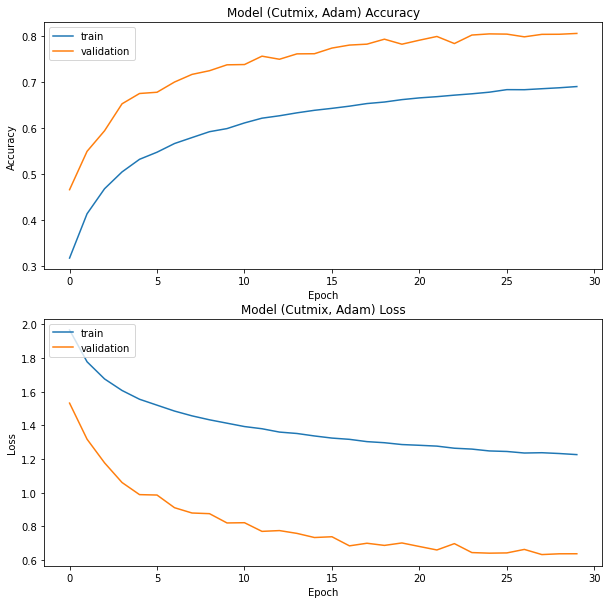

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHistAP.history['accuracy'])  
plt.plot(cnnHistAP.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHistAP.history['loss'])  
plt.plot(cnnHistAP.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

**Compare the performance of three DNN model with Max pooling/No pooling/Average pooling curve Graph**

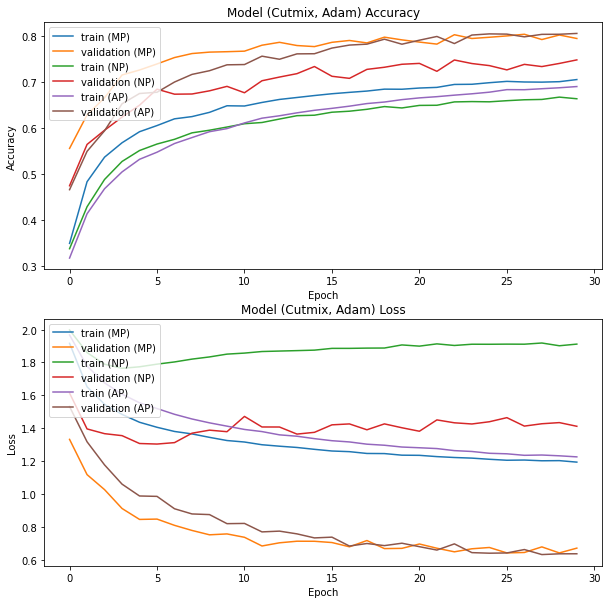

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHistMP.history['accuracy'])  
plt.plot(cnnHistMP.history['val_accuracy']) 
plt.plot(cnnHistNP.history['accuracy'])  
plt.plot(cnnHistNP.history['val_accuracy']) 
plt.plot(cnnHistAP.history['accuracy'])  
plt.plot(cnnHistAP.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train (MP)', 'validation (MP)', 'train (NP)', 'validation (NP)', 
            'train (AP)', 'validation (AP)'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHistMP.history['loss'])  
plt.plot(cnnHistMP.history['val_loss']) 
plt.plot(cnnHistNP.history['loss'])  
plt.plot(cnnHistNP.history['val_loss']) 
plt.plot(cnnHistAP.history['loss'])  
plt.plot(cnnHistAP.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train (MP)', 'validation (MP)', 'train (NP)', 'validation (NP)', 
            'train (AP)', 'validation (AP)'], loc = 'upper left')  

plt.show()

DNN Setting  | Accuracy Score | Loss score
-------------------|--------------------|------------------
With Max Pooling           | 79.40% | 67.09%
Without Max Pooling       | 74.75% | 141.18%
With Average Pooling ★   | 80.50% | 63.66%%

The case of 3 hidden layers of DNN implemented with Max pooling, Average pooling, and without max-pooling shows different accuracy and loss score. DNN model with average pooling shows the best score among them, and without max-pooling model shows the worst score. Especially comparing the max pooling and average pooling, In training at the 16-18 epoch level, DNNs with max-pooling layers score higher, but beyond that, models with average pooling layers score higher.

So, I selected the **average pooling** layers with the final version of the DNN structure since I guessed if training with a higher epochs number is carried out, it is expected that the average pooling layer will score better than the max-pooling layer.

> ***Case reflected in the final DNN structure: Average Pooling layer***

## 3.8) **Activation func: Tanh vs relu vs Leaky Relu**

### 3.8.1) **Activation func: Tanh**

In [ ]:
input_size = x_train.shape[1:]
dropout = 0.05 # reflect the section 3.4 result (DNN with Dropout(0.05) shows a better accuracy and loss score)

cnnT = Sequential()
# Input layer
cnnT.add(Convolution2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'tanh', input_shape = x_train.shape[1:]))
cnnT.add(AveragePooling2D(pool_size = 2))
cnnT.add(Dropout(dropout))
# Hidden layer 1
cnnT.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'tanh'))
cnnT.add(AveragePooling2D(pool_size = 2))
cnnT.add(Dropout(dropout))
# Hidden layer 2
cnnT.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'tanh'))
cnnT.add(AveragePooling2D(pool_size = 2))
cnnT.add(Dropout(dropout))
# Hidden layer 3
cnnT.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'tanh'))
cnnT.add(AveragePooling2D(pool_size = 2))
cnnT.add(Dropout(dropout))

cnnT.add(Flatten())
cnnT.add(Dropout(dropout))

# Output layer
cnnT.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnnT.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 average_pooling2d_4 (Averag  (None, 16, 16, 64)       0         
 ePooling2D)                                                     
                                                                 
 dropout_15 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 average_pooling2d_5 (Averag  (None, 8, 8, 128)        0         
 ePooling2D)                                                     
                                                                 
 dropout_16 (Dropout)        (None, 8, 8, 128)        

In [ ]:
cnnT.save_weights("initial_weights.h5")

In [ ]:
cnnT.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnnT.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"]) 
cnnHistT = cnnT.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30, batch_size = 16)
# reflect the section 3.6 result (DNN with Batch size: 16 shows a better accuracy and loss score)

test_loss, test_accuracy = cnnT.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 59s 36ms/step - loss: 2.0536 - accuracy: 0.2910 - val_loss: 1.6393 - val_accuracy: 0.4249
Epoch 2/30
1563/1563 [==============================] - 50s 31ms/step - loss: 1.8630 - accuracy: 0.3764 - val_loss: 1.4583 - val_accuracy: 0.5129
Epoch 3/30
1563/1563 [==============================] - 38s 24ms/step - loss: 1.7942 - accuracy: 0.4137 - val_loss: 1.4194 - val_accuracy: 0.5211
Epoch 4/30
1563/1563 [==============================] - 38s 24ms/step - loss: 1.7551 - accuracy: 0.4354 - val_loss: 1.3232 - val_accuracy: 0.5623
Epoch 5/30
1563/1563 [==============================] - 38s 24ms/step - loss: 1.7214 - accuracy: 0.4530 - val_loss: 1.2945 - val_accuracy: 0.5722
Epoch 6/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.6922 - accuracy: 0.4673 - val_loss: 1.2802 - val_accuracy: 0.5663
Epoch 7/30
1563/1563 [==============================] - 49s 31ms/step - loss: 1.6676 - accuracy: 0.4786 - val_loss: 1.2273 -

### 3.8.2) **Activation func: relu**

In [ ]:
input_size = x_train.shape[1:]
dropout = 0.05 # reflect the section 3.4 result (DNN with Dropout(0.05) shows a better accuracy and loss score)

cnnS = Sequential()
# Input layer
cnnS.add(Convolution2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
cnnS.add(AveragePooling2D(pool_size = 2))
cnnS.add(Dropout(dropout))
# Hidden layer 1
cnnS.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnnS.add(AveragePooling2D(pool_size = 2))
cnnS.add(Dropout(dropout))
# Hidden layer 2
cnnS.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnnS.add(AveragePooling2D(pool_size = 2))
cnnS.add(Dropout(dropout))
# Hidden layer 3
cnnS.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnnS.add(AveragePooling2D(pool_size = 2))
cnnS.add(Dropout(dropout))

cnnS.add(Flatten())
cnnS.add(Dropout(dropout))

# Output layer
cnnS.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnnS.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 average_pooling2d_8 (Averag  (None, 16, 16, 64)       0         
 ePooling2D)                                                     
                                                                 
 dropout_20 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 average_pooling2d_9 (Averag  (None, 8, 8, 128)        0         
 ePooling2D)                                                     
                                                                 
 dropout_21 (Dropout)        (None, 8, 8, 128)        

In [ ]:
cnnS.save_weights("initial_weights.h5")

In [ ]:
cnnS.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnnS.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
cnnHistS = cnnS.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30, batch_size = 16)
# reflect the section 3.6 result (DNN with Batch size: 16 shows a better accuracy and loss score)

test_loss, test_accuracy = cnnS.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 40s 25ms/step - loss: 1.9713 - accuracy: 0.3118 - val_loss: 1.5329 - val_accuracy: 0.4706
Epoch 2/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.7721 - accuracy: 0.4187 - val_loss: 1.3146 - val_accuracy: 0.5461
Epoch 3/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.6822 - accuracy: 0.4645 - val_loss: 1.1660 - val_accuracy: 0.6150
Epoch 4/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.6213 - accuracy: 0.4934 - val_loss: 1.1051 - val_accuracy: 0.6362
Epoch 5/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5644 - accuracy: 0.5230 - val_loss: 1.0436 - val_accuracy: 0.6528
Epoch 6/30
1563/1563 [==============================] - 35s 23ms/step - loss: 1.5256 - accuracy: 0.5425 - val_loss: 0.9646 - val_accuracy: 0.6898
Epoch 7/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.4930 - accuracy: 0.5580 - val_loss: 0.9876 -

### 3.8.3) **Activation func: Leaky Relu**

In [ ]:
from keras.layers import LeakyReLU

In [ ]:
input_size = x_train.shape[1:]
dropout = 0.05 # reflect the section 3.4 result (DNN with Dropout(0.05) shows a better accuracy and loss score)
cnnL = Sequential()
# Input layer
cnnL.add(Convolution2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', 
                       activation = tf.keras.layers.LeakyReLU(alpha = 0.1), input_shape = x_train.shape[1:]))
cnnL.add(AveragePooling2D(pool_size = 2))
cnnL.add(Dropout(dropout))
# Hidden layer 1
cnnL.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
cnnL.add(AveragePooling2D(pool_size = 2))
cnnL.add(Dropout(dropout))
# Hidden layer 2
cnnL.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
cnnL.add(AveragePooling2D(pool_size = 2))
cnnL.add(Dropout(dropout))
# Hidden layer 3
cnnL.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
cnnL.add(AveragePooling2D(pool_size = 2))
cnnL.add(Dropout(dropout))

cnnL.add(Flatten())
cnnL.add(Dropout(dropout))

# Output layer
cnnL.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnnL.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 average_pooling2d_12 (Avera  (None, 16, 16, 64)       0         
 gePooling2D)                                                    
                                                                 
 dropout_25 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 average_pooling2d_13 (Avera  (None, 8, 8, 128)        0         
 gePooling2D)                                                    
                                                                 
 dropout_26 (Dropout)        (None, 8, 8, 128)        

In [ ]:
cnnL.save_weights("initial_weights.h5")

In [ ]:
cnnL.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnnL.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
cnnHistL = cnnL.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30, batch_size = 16)
# reflect the section 3.6 result (DNN with Batch size: 16 shows a better accuracy and loss score)

test_loss, test_accuracy = cnnL.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 37s 23ms/step - loss: 1.9433 - accuracy: 0.3339 - val_loss: 1.4264 - val_accuracy: 0.4966
Epoch 2/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.7464 - accuracy: 0.4328 - val_loss: 1.2609 - val_accuracy: 0.5823
Epoch 3/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.6380 - accuracy: 0.4893 - val_loss: 1.1092 - val_accuracy: 0.6386
Epoch 4/30
1563/1563 [==============================] - 35s 23ms/step - loss: 1.5750 - accuracy: 0.5217 - val_loss: 1.0139 - val_accuracy: 0.6665
Epoch 5/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.5251 - accuracy: 0.5487 - val_loss: 0.9441 - val_accuracy: 0.6964
Epoch 6/30
1563/1563 [==============================] - 35s 23ms/step - loss: 1.4854 - accuracy: 0.5658 - val_loss: 0.8949 - val_accuracy: 0.7163
Epoch 7/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.4585 - accuracy: 0.5801 - val_loss: 0.8730 -

**Compare the performance of two DNN models with Tanh/Leaky Relu activation through curve Graph**

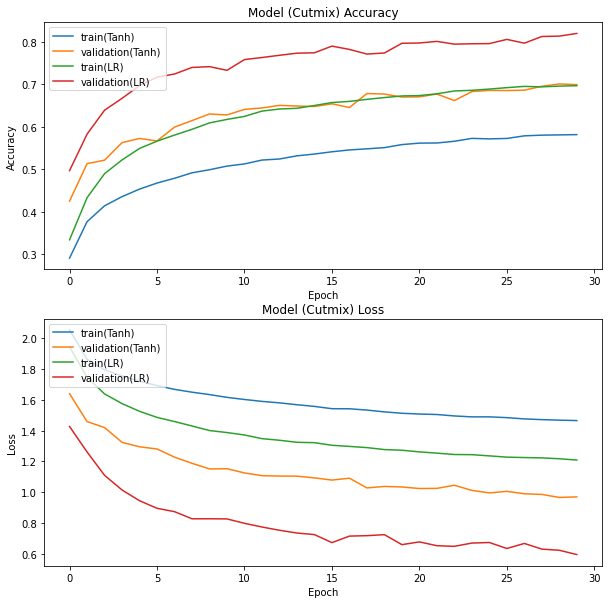

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)  
plt.plot(cnnHistT.history['accuracy'])  
plt.plot(cnnHistT.history['val_accuracy'])   
plt.plot(cnnHistL.history['accuracy'])  
plt.plot(cnnHistL.history['val_accuracy']) 
plt.title('Model (Cutmix) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train(Tanh)', 'validation(Tanh)', 'train(LR)', 'validation(LR)'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)  
plt.plot(cnnHistT.history['loss'])  
plt.plot(cnnHistT.history['val_loss'])  
plt.plot(cnnHistL.history['loss'])  
plt.plot(cnnHistL.history['val_loss']) 
plt.title('Model (Cutmix) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train(Tanh)', 'validation(Tanh)', 'train(LR)', 'validation(LR)'], loc = 'upper left')  
plt.show()

**Compare the performance of three DNN models with Tanh/Relu/Leaky Relu activation through curve Graph**

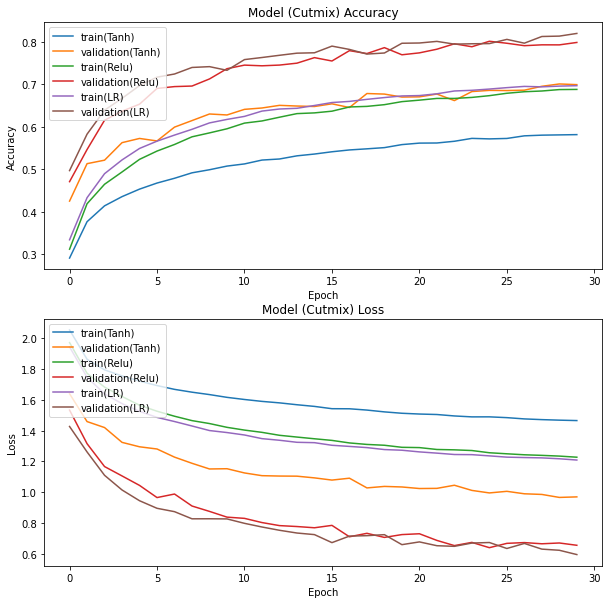

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)  
plt.plot(cnnHistT.history['accuracy'])  
plt.plot(cnnHistT.history['val_accuracy'])  
plt.plot(cnnHistS.history['accuracy'])  
plt.plot(cnnHistS.history['val_accuracy'])  
plt.plot(cnnHistL.history['accuracy'])  
plt.plot(cnnHistL.history['val_accuracy']) 
plt.title('Model (Cutmix) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train(Tanh)', 'validation(Tanh)', 'train(Relu)', 'validation(Relu)', 'train(LR)', 'validation(LR)'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)  
plt.plot(cnnHistT.history['loss'])  
plt.plot(cnnHistT.history['val_loss'])  
plt.plot(cnnHistS.history['loss'])  
plt.plot(cnnHistS.history['val_loss']) 
plt.plot(cnnHistL.history['loss'])  
plt.plot(cnnHistL.history['val_loss']) 
plt.title('Model (Cutmix) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train(Tanh)', 'validation(Tanh)', 'train(Relu)', 'validation(Relu)', 'train(LR)', 'validation(LR)'], loc = 'upper left')  
plt.show()

DNN Setting  | Accuracy Score | Loss score
-------------------|--------------------|------------------
Act func: Tanh           | 69.87% | 96.90%
Act func: Relu        | 79.79% | 65.46%
Act func: Leaky Relu★   | 81.91% | 59.43%

The case of 3 hidden layers of DNN with Leaky ReLU activation function shows a better accuracy and loss score. Therefore, included **Leaky ReLU** layers in the final version of the DNN structure.

> ***Case reflected in the final DNN structure: Act func - Leaky ReLU***

## 3.9) **Learning Rate** 

In [ ]:
from keras import backend as K
INIT_LR = 5e-3  # initial learning rate

In [ ]:
input_size = x_train.shape[1:]
dropout = 0.05 # reflect the section 4.4 result (DNN with Dropout(0.05) shows a better accuracy and loss score)
# model is a 3-layer CNN with Leaky ReLU and dropout after each layer

cnnLearning = Sequential()
# Input layer
cnnLearning.add(Convolution2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1), 
                              input_shape = x_train.shape[1:]))
cnnLearning.add(AveragePooling2D(pool_size = 2))
cnnLearning.add(Dropout(dropout))
# Hidden layer 1
cnnLearning.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
cnnLearning.add(AveragePooling2D(pool_size = 2))
cnnLearning.add(Dropout(dropout))
# Hidden layer 2
cnnLearning.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
cnnLearning.add(AveragePooling2D(pool_size = 2))
cnnLearning.add(Dropout(dropout))
# Hidden layer 3
cnnLearning.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
cnnLearning.add(AveragePooling2D(pool_size = 2))
cnnLearning.add(Dropout(dropout))

cnnLearning.add(Flatten())
cnnLearning.add(Dropout(dropout))

# Output layer
cnnLearning.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnnLearning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 64)       0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 average_pooling2d_1 (Averag  (None, 8, 8, 128)        0         
 ePooling2D)                                                     
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0

### 3.9.1) **Learning Rate scheduler**

In [ ]:
from keras import backend as K

In [ ]:
cnnLearning.compile(
    loss = 'categorical_crossentropy',  
    optimizer = tf.keras.optimizers.Adam(INIT_LR),
    metrics = ['accuracy']  # report accuracy during training
)

In [ ]:
# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

In [ ]:
# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(cnnLearning.optimizer.lr))

In [ ]:
cnnLearning.fit(
    train_data_cutMix, validation_data = test_data_set,
    epochs = 10,
    batch_size = 16,
    callbacks = [keras.callbacks.LearningRateScheduler(lr_scheduler), LrHistory()],
    shuffle = True,
    verbose = 1
)

Learning rate: 0.005
Epoch 1/10
1563/1563 [==============================] - 50s 25ms/step - loss: 29.4327 - accuracy: 0.2406 - val_loss: 10.9753 - val_accuracy: 0.1431 - lr: 0.0050
Learning rate: 0.0045
Epoch 2/10
1563/1563 [==============================] - 36s 23ms/step - loss: 4.2626 - accuracy: 0.1569 - val_loss: 3.2537 - val_accuracy: 0.2664 - lr: 0.0045
Learning rate: 0.00405
Epoch 3/10
1563/1563 [==============================] - 37s 23ms/step - loss: 3.2701 - accuracy: 0.2148 - val_loss: 2.7434 - val_accuracy: 0.3117 - lr: 0.0041
Learning rate: 0.003645
Epoch 4/10
1563/1563 [==============================] - 38s 24ms/step - loss: 2.7774 - accuracy: 0.2624 - val_loss: 2.2454 - val_accuracy: 0.3830 - lr: 0.0036
Learning rate: 0.0032805
Epoch 5/10
1563/1563 [==============================] - 37s 24ms/step - loss: 2.3470 - accuracy: 0.3011 - val_loss: 1.8748 - val_accuracy: 0.4060 - lr: 0.0033
Learning rate: 0.00295245
Epoch 6/10
1563/1563 [==============================] - 36s 23

### 3.9.2) **Learning Rate: 1e-2**

In [ ]:
input_size = x_train.shape[1:]
dropout = 0.05 # reflect the section 3.4 result (DNN with Dropout(0.05) shows a better accuracy and loss score)
# model is a 3-layer CNN with Leaky ReLU and dropout after each layer

cnnE2 = Sequential()
# Input layer
cnnE2.add(Convolution2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1), 
                              input_shape = x_train.shape[1:]))
cnnE2.add(AveragePooling2D(pool_size = 2))
cnnE2.add(Dropout(dropout))
# Hidden layer 1
cnnE2.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
cnnE2.add(AveragePooling2D(pool_size = 2))
cnnE2.add(Dropout(dropout))
# Hidden layer 2
cnnE2.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
cnnE2.add(AveragePooling2D(pool_size = 2))
cnnE2.add(Dropout(dropout))
# Hidden layer 3
cnnE2.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
cnnE2.add(AveragePooling2D(pool_size = 2))
cnnE2.add(Dropout(dropout))

cnnE2.add(Flatten())
cnnE2.add(Dropout(dropout))

# Output layer
cnnE2.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnnE2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 average_pooling2d_28 (Avera  (None, 16, 16, 64)       0         
 gePooling2D)                                                    
                                                                 
 dropout_35 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 average_pooling2d_29 (Avera  (None, 8, 8, 128)        0         
 gePooling2D)                                                    
                                                                 
 dropout_36 (Dropout)        (None, 8, 8, 128)        

In [ ]:
cnnE2.save_weights("initial_weights.h5")

In [ ]:
cnnE2.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnnE2.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(1e-2), metrics = ["accuracy"]) 
# 1e-2 = 0.01
cnnHistE2 = cnnE2.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30, batch_size = 16)
# reflect the section 3.6 result (DNN with Batch size: 16 shows a better accuracy and loss score)

test_loss, test_accuracy = cnnE2.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 33s 21ms/step - loss: 3.0516 - accuracy: 0.1987 - val_loss: 1.9057 - val_accuracy: 0.3035
Epoch 2/30
1563/1563 [==============================] - 33s 21ms/step - loss: 2.0229 - accuracy: 0.2993 - val_loss: 1.7399 - val_accuracy: 0.3694
Epoch 3/30
1563/1563 [==============================] - 33s 21ms/step - loss: 906.0360 - accuracy: 0.3031 - val_loss: 65.7399 - val_accuracy: 0.1019
Epoch 4/30
1563/1563 [==============================] - 32s 21ms/step - loss: 26.2087 - accuracy: 0.1253 - val_loss: 8.5173 - val_accuracy: 0.1902
Epoch 5/30
1563/1563 [==============================] - 33s 21ms/step - loss: 13.5624 - accuracy: 0.1310 - val_loss: 6.7215 - val_accuracy: 0.2181
Epoch 6/30
1563/1563 [==============================] - 34s 21ms/step - loss: 5657.7280 - accuracy: 0.1393 - val_loss: 59595.9023 - val_accuracy: 0.1000
Epoch 7/30
1563/1563 [==============================] - 33s 21ms/step - loss: 1494.0521 - accuracy: 0.1145 - val

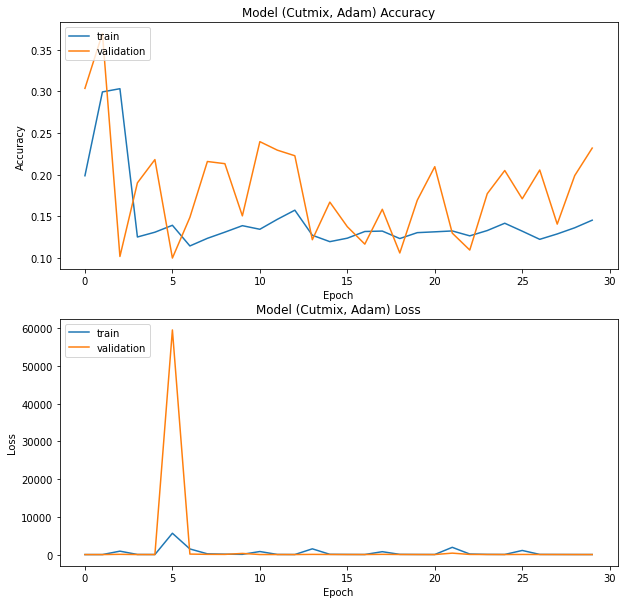

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHistE2.history['accuracy'])  
plt.plot(cnnHistE2.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHistE2.history['loss'])  
plt.plot(cnnHistE2.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

### 3.9.3) **Learning Rate: 1e-3**

In [ ]:
input_size = x_train.shape[1:]
dropout = 0.05 # reflect the section 3.4 result (DNN with Dropout(0.05) shows a better accuracy and loss score)
# model is a 3-layer CNN with Leaky ReLU and dropout after each layer

cnnE3 = Sequential()
# Input layer
cnnE3.add(Convolution2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1), 
                              input_shape = x_train.shape[1:]))
cnnE3.add(AveragePooling2D(pool_size = 2))
cnnE3.add(Dropout(dropout))
# Hidden layer 1
cnnE3.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
cnnE3.add(AveragePooling2D(pool_size = 2))
cnnE3.add(Dropout(dropout))
# Hidden layer 2
cnnE3.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
cnnE3.add(AveragePooling2D(pool_size = 2))
cnnE3.add(Dropout(dropout))
# Hidden layer 3
cnnE3.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
cnnE3.add(AveragePooling2D(pool_size = 2))
cnnE3.add(Dropout(dropout))

cnnE3.add(Flatten())
cnnE3.add(Dropout(dropout))

# Output layer
cnnE3.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnnE3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 average_pooling2d_36 (Avera  (None, 16, 16, 64)       0         
 gePooling2D)                                                    
                                                                 
 dropout_45 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 average_pooling2d_37 (Avera  (None, 8, 8, 128)        0         
 gePooling2D)                                                    
                                                                 
 dropout_46 (Dropout)        (None, 8, 8, 128)        

In [ ]:
cnnE3.save_weights("initial_weights.h5")

In [ ]:
cnnE3.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnnE3.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(1e-3), metrics = ["accuracy"]) 
# 1e-3 = 0.001
cnnHistE3 = cnnE3.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30, batch_size = 16)
# reflect the section 3.6 result (DNN with Batch size: 16 shows a better accuracy and loss score)

test_loss, test_accuracy = cnnE3.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 33s 21ms/step - loss: 1.9521 - accuracy: 0.3317 - val_loss: 1.4275 - val_accuracy: 0.4979
Epoch 2/30
1563/1563 [==============================] - 33s 21ms/step - loss: 1.7429 - accuracy: 0.4356 - val_loss: 1.2776 - val_accuracy: 0.5682
Epoch 3/30
1563/1563 [==============================] - 33s 21ms/step - loss: 1.6458 - accuracy: 0.4812 - val_loss: 1.1418 - val_accuracy: 0.6198
Epoch 4/30
1563/1563 [==============================] - 33s 21ms/step - loss: 1.5826 - accuracy: 0.5189 - val_loss: 1.0583 - val_accuracy: 0.6544
Epoch 5/30
1563/1563 [==============================] - 33s 21ms/step - loss: 1.5338 - accuracy: 0.5448 - val_loss: 0.9538 - val_accuracy: 0.6887
Epoch 6/30
1563/1563 [==============================] - 33s 21ms/step - loss: 1.4928 - accuracy: 0.5591 - val_loss: 0.9265 - val_accuracy: 0.7109
Epoch 7/30
1563/1563 [==============================] - 32s 21ms/step - loss: 1.4613 - accuracy: 0.5764 - val_loss: 0.9049 -

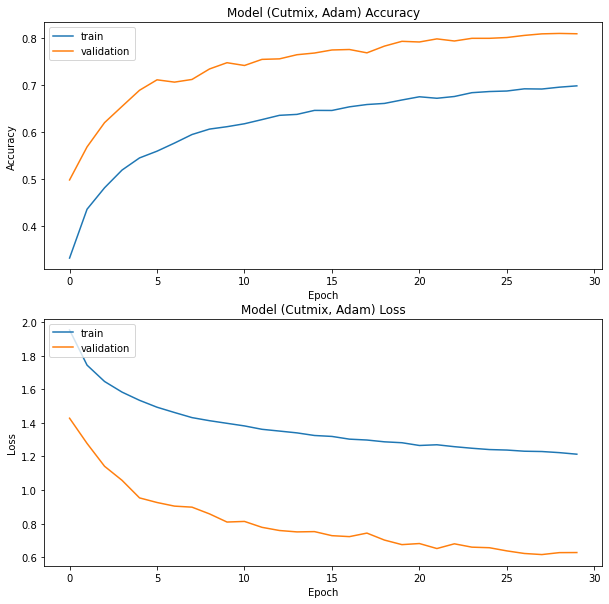

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHistE3.history['accuracy'])  
plt.plot(cnnHistE3.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHistE3.history['loss'])  
plt.plot(cnnHistE3.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

### 3.9.4) **Learning Rate: 1e-4**

In [ ]:
input_size = x_train.shape[1:]
dropout = 0.05 # reflect the section 3.4 result (DNN with Dropout(0.05) shows a better accuracy and loss score)
# model is a 3-layer CNN with Leaky ReLU and dropout after each layer

cnnE4 = Sequential()
# Input layer
cnnE4.add(Convolution2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1), 
                              input_shape = x_train.shape[1:]))
cnnE4.add(AveragePooling2D(pool_size = 2))
cnnE4.add(Dropout(dropout))
# Hidden layer 1
cnnE4.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
cnnE4.add(AveragePooling2D(pool_size = 2))
cnnE4.add(Dropout(dropout))
# Hidden layer 2
cnnE4.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
cnnE4.add(AveragePooling2D(pool_size = 2))
cnnE4.add(Dropout(dropout))
# Hidden layer 3
cnnE4.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
cnnE4.add(AveragePooling2D(pool_size = 2))
cnnE4.add(Dropout(dropout))

cnnE4.add(Flatten())
cnnE4.add(Dropout(dropout))

# Output layer
cnnE4.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

cnnE4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 average_pooling2d_24 (Avera  (None, 16, 16, 64)       0         
 gePooling2D)                                                    
                                                                 
 dropout_30 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 average_pooling2d_25 (Avera  (None, 8, 8, 128)        0         
 gePooling2D)                                                    
                                                                 
 dropout_31 (Dropout)        (None, 8, 8, 128)        

In [ ]:
cnnE4.save_weights("initial_weights.h5")

In [ ]:
cnnE4.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

cnnE4.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(1e-4), metrics = ["accuracy"]) 
# 1e-4 = 0.0001
cnnHistE4 = cnnE4.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30, batch_size = 16)
# reflect the section 3.6 result (DNN with Batch size: 16 shows a better accuracy and loss score)

test_loss, test_accuracy = cnnE4.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}%".format(test_loss * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 34s 21ms/step - loss: 2.1455 - accuracy: 0.2678 - val_loss: 1.7899 - val_accuracy: 0.3995
Epoch 2/30
1563/1563 [==============================] - 33s 21ms/step - loss: 1.9743 - accuracy: 0.3324 - val_loss: 1.6777 - val_accuracy: 0.4200
Epoch 3/30
1563/1563 [==============================] - 33s 21ms/step - loss: 1.9059 - accuracy: 0.3597 - val_loss: 1.5728 - val_accuracy: 0.4621
Epoch 4/30
1563/1563 [==============================] - 33s 21ms/step - loss: 1.8651 - accuracy: 0.3789 - val_loss: 1.5189 - val_accuracy: 0.4790
Epoch 5/30
1563/1563 [==============================] - 33s 21ms/step - loss: 1.8351 - accuracy: 0.3874 - val_loss: 1.4733 - val_accuracy: 0.4891
Epoch 6/30
1563/1563 [==============================] - 33s 21ms/step - loss: 1.8145 - accuracy: 0.4015 - val_loss: 1.4593 - val_accuracy: 0.5049
Epoch 7/30
1563/1563 [==============================] - 32s 21ms/step - loss: 1.7898 - accuracy: 0.4071 - val_loss: 1.4283 -

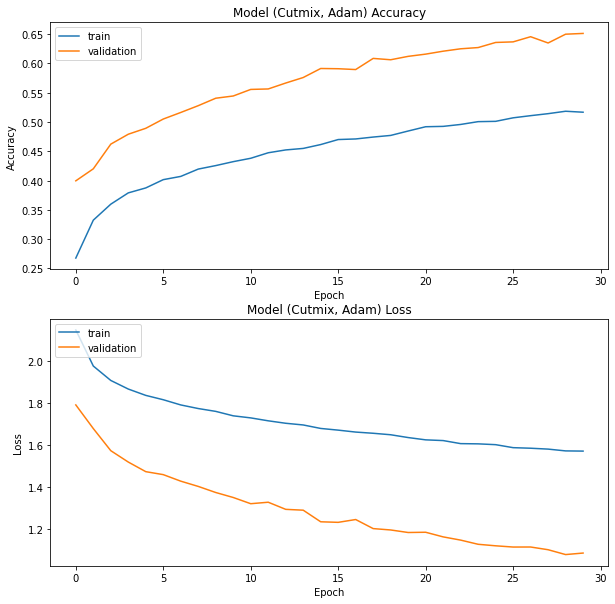

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(cnnHistE4.history['accuracy'])  
plt.plot(cnnHistE4.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(cnnHistE4.history['loss'])  
plt.plot(cnnHistE4.history['val_loss']) 
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

**Compare the performance of three DNN models with 1e-2/1e-3/1e-4 learning rate through curve Graph**

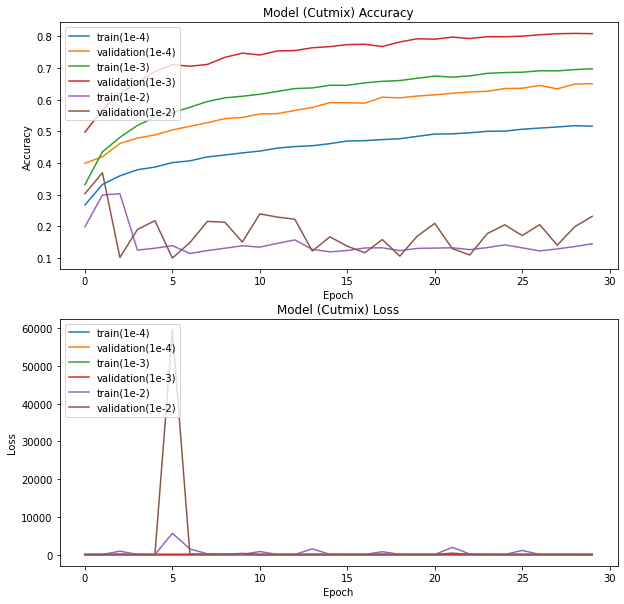

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)  
plt.plot(cnnHistE4.history['accuracy'])  
plt.plot(cnnHistE4.history['val_accuracy']) 
plt.plot(cnnHistE3.history['accuracy'])  
plt.plot(cnnHistE3.history['val_accuracy'])  
plt.plot(cnnHistE2.history['accuracy'])  
plt.plot(cnnHistE2.history['val_accuracy'])  
plt.title('Model (Cutmix) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train(1e-4)', 'validation(1e-4)', 'train(1e-3)', 'validation(1e-3)', 'train(1e-2)', 'validation(1e-2)'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)  
plt.plot(cnnHistE4.history['loss'])  
plt.plot(cnnHistE4.history['val_loss']) 
plt.plot(cnnHistE3.history['loss'])  
plt.plot(cnnHistE3.history['val_loss'])  
plt.plot(cnnHistE2.history['loss'])  
plt.plot(cnnHistE2.history['val_loss']) 
plt.title('Model (Cutmix) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train(1e-4)', 'validation(1e-4)', 'train(1e-3)', 'validation(1e-3)', 'train(1e-2)', 'validation(1e-2)'], loc = 'upper left')  
plt.show()

Since the DNN model with a 1e-2 learning rate loss score is too big, I cannot compare the 1e-4 and 1e-3 performance, so I compare the 1e-4 and 1e-3 separately.

**Compare the performance of two DNN models with 1e-4/1e-3 learining rate through curve Graph**

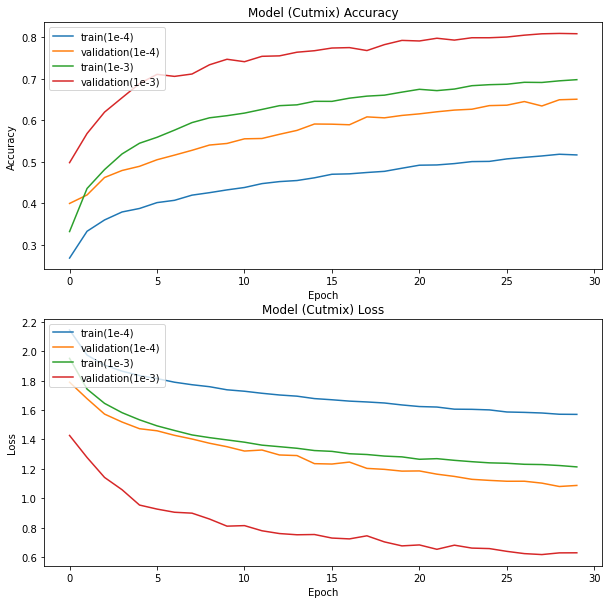

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)  
plt.plot(cnnHistE4.history['accuracy'])  
plt.plot(cnnHistE4.history['val_accuracy']) 
plt.plot(cnnHistE3.history['accuracy'])  
plt.plot(cnnHistE3.history['val_accuracy'])  
plt.title('Model (Cutmix) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train(1e-4)', 'validation(1e-4)', 'train(1e-3)', 'validation(1e-3)'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)  
plt.plot(cnnHistE4.history['loss'])  
plt.plot(cnnHistE4.history['val_loss']) 
plt.plot(cnnHistE3.history['loss'])  
plt.plot(cnnHistE3.history['val_loss'])  
plt.title('Model (Cutmix) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train(1e-4)', 'validation(1e-4)', 'train(1e-3)', 'validation(1e-3)'], loc = 'upper left')  
plt.show()

DNN Setting  | Accuracy Score | Loss score
-------------------|--------------------|------------------
Learning Rate = 1e-2      | 23.19% | 938.23%
Learning Rate = 1e-3 ★   | 80.89% | 62.90%
Learning Rate = 1e-4       | 65.09% | 108.74%

The case of 3 hidden layers of DNN with Learning rate:1e-3 shows a better accuracy and loss score. Therefore, included **Learning rate:1e-3** value in the final version of the DNN structure.

> ***Case reflected in the final DNN structure:Learning rate:1e-3***

# 4) **Cutmix vs none Cutmix with comparing optimizer**

After tuned the hyperparemeters of the DNN model, training the data for evaluate in the following four types in this sections:

1) Train the model with the dataset augmented by ***CutMix*** and ***Adam*** optimizer

2) Train the model with the dataset augmented by ***CutMix*** and ***RMSProp*** optimizer

3) Train the model with the dataset in the ***normal*** way and ***Adam*** optimizer

4) Train the model with the dataset in the ***normal*** way and ***RMSProp*** optimizer

While training through these four methods, I try to analyze the effects of the ***Cutmix*** argument method and compare the efficiency of ***Adam*** and ***RMSProp*** optimizer (hyperparameter).

In [ ]:
# Define the model

input_size = x_train.shape[1:]
# model is a 3-layer CNN with Leaku ReLU and dropout after each layer
model = Sequential()

# Input layer
model.add(Convolution2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1), 
                        input_shape = x_train.shape[1:]))
model.add(AveragePooling2D(pool_size = 2))
model.add(Dropout(0.05))

# 1st Hidden layer 
model.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
model.add(AveragePooling2D(pool_size = 2))
model.add(Dropout(0.05))
# 2nd Hidden layer 
model.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
model.add(AveragePooling2D(pool_size = 2))
model.add(Dropout(0.05))
# 3rd Hidden layer 
model.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
model.add(AveragePooling2D(pool_size = 2))
model.add(Dropout(0.05))

model.add(Flatten())
model.add(Dropout(0.05))

# Output layer
model.add(Dense(10, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01)))

model.summary()

# The input image passes through the convolution layer, and the max-pooling layer and removes spatial information.
# The result is become to flatten, and then add two layers that are fully connected rather than locally connected.
# In the meantime, a dropout layer is added and minimizes over-fitting.
# This network uses only a much smaller number of parameters than MLP (MLP: 3,590,642 CNN: 528,054), but its ability to classify images is stronger.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 average_pooling2d_8 (Averag  (None, 16, 16, 64)       0         
 ePooling2D)                                                     
                                                                 
 dropout_10 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 average_pooling2d_9 (Averag  (None, 8, 8, 128)        0         
 ePooling2D)                                                     
                                                                 
 dropout_11 (Dropout)        (None, 8, 8, 128)        

In [ ]:
model.save_weights("initial_weights.h5")

## 4.1) **Training the data with Cutmix (Adam/Rmsprop)**

The loss function has to be categorical_crossentropy since I deal with categorical labels. The same goes for the last activation which has to be softmax since dataset have more than two classes (sigmoid would be fine for two classes).

* One of the major reasons for overfitting is that you don’t have enough data to train your network.
* Apart from regularization, another very effective way to counter Overfitting is **Data Augmentation**.
* It is the process of artificially creating more images from the images you already have by changing the size, orientation etc of the image.
* This can be done in Keras using the ImageDataGenerator instance, but in this assignment, **cutmix** is used.
* Includes rotation of the image, shifting the image left/right/top/bottom by some amount, flip the image horizontally or vertically, shear or zoom the image etc.
* Augmentation has a **regularizing effect**. Too much of this combined with other forms of regularization (weight L2, dropout, etc.) can cause the net to **underfit**.

**Cutmix : Optimizer - Adam (30 epochs)**

**Compiling the network**
* Compile the network that have just built by calling compile function
* Parameters:
> * optimizer: Algorithm used by Keras to minimize the prediction scoring metric
> * loss: The objective function that will be minimized by the model
> * metrics: List of metrics to be evaluated by the model during training and testing

In [ ]:
model.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(1e-3), metrics = ["accuracy"]) 
histMixAdam = model.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30, batch_size = 16)
# reflect the section 3.6 result (DNN with Batch size: 16 shows a better accuracy and loss score)

test_loss, test_accuracy = model.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 45s 28ms/step - loss: 1.9484 - accuracy: 0.3274 - val_loss: 1.4336 - val_accuracy: 0.4954
Epoch 2/30
1563/1563 [==============================] - 36s 23ms/step - loss: 1.7487 - accuracy: 0.4320 - val_loss: 1.2497 - val_accuracy: 0.5776
Epoch 3/30
1563/1563 [==============================] - 39s 25ms/step - loss: 1.6473 - accuracy: 0.4825 - val_loss: 1.1469 - val_accuracy: 0.6261
Epoch 4/30
1563/1563 [==============================] - 35s 22ms/step - loss: 1.5783 - accuracy: 0.5199 - val_loss: 1.0174 - val_accuracy: 0.6668
Epoch 5/30
1563/1563 [==============================] - 49s 31ms/step - loss: 1.5255 - accuracy: 0.5489 - val_loss: 0.9857 - val_accuracy: 0.6817
Epoch 6/30
1563/1563 [==============================] - 40s 25ms/step - loss: 1.4851 - accuracy: 0.5639 - val_loss: 0.9460 - val_accuracy: 0.7055
Epoch 7/30
1563/1563 [==============================] - 43s 28ms/step - loss: 1.4536 - accuracy: 0.5825 - val_loss: 0.8786 -

In [ ]:
print("Test accuracy (optimizer: Adam / Epochs: 30): {:.2f}%".format(test_accuracy * 100))
print("Test loss (optimizer: Adam / Epochs: 30) : {:.2f}%".format(test_loss * 100))

Test accuracy (optimizer: Adam / Epochs: 30): 80.65%
Test loss (optimizer: Adam / Epochs: 30) : 63.98%


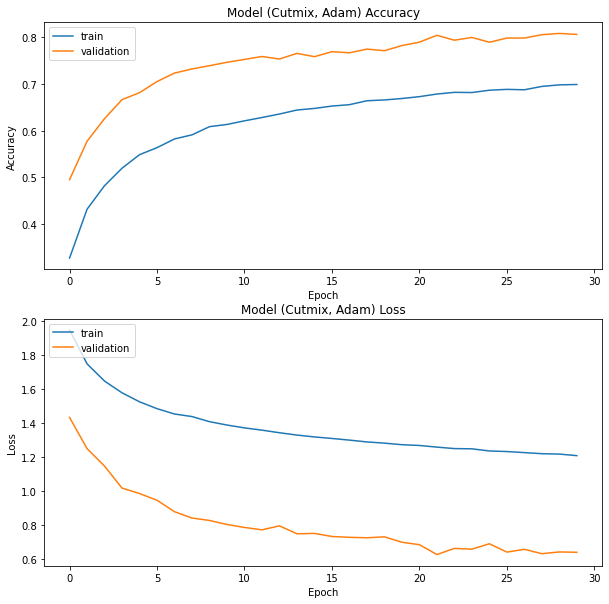

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)  
plt.plot(histMixAdam.history['accuracy'])  
plt.plot(histMixAdam.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)  
plt.plot(histMixAdam.history['loss'])  
plt.plot(histMixAdam.history['val_loss'])  
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

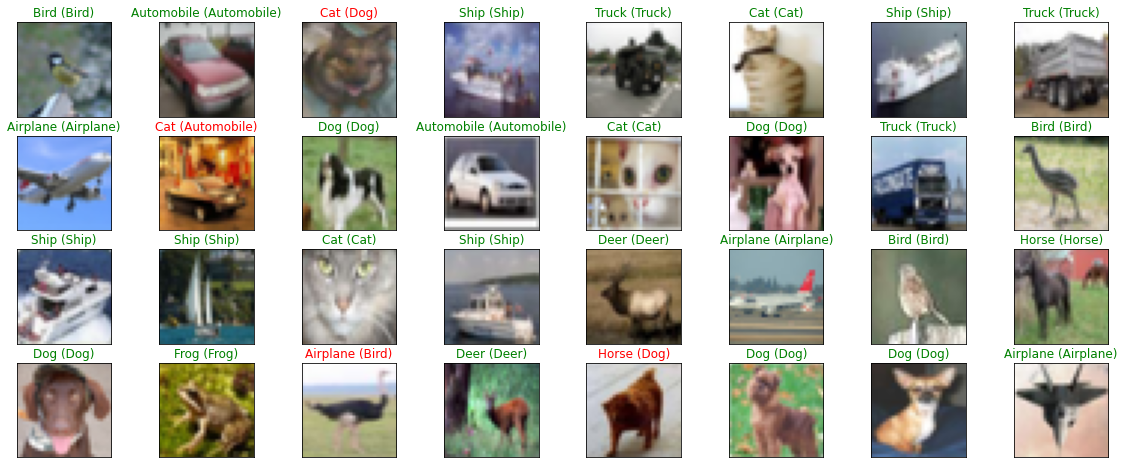

In [ ]:
# using the model to predict on test ds data

y_pred = model.predict(test_data_set)

# plot a random sample of test images, their predicted labels, and ground truth

fig = plt.figure(figsize = (20,8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size = 32, replace = False)):
  ax = fig.add_subplot(4, 8, i+1, xticks = [], yticks = [])
  ax.imshow(np.squeeze(x_test[idx]))
  pred_idx = np.argmax(y_pred[idx])
  true_idx = np.argmax(y_test[idx])
  ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
               color=('green' if pred_idx == true_idx else 'red'))
  
 # Correct predict images : Green
 # Wrong predict images : Red 

**Cutmix : Optimizer - Rmsprop (30 epochs)**

In [ ]:
model.load_weights("initial_weights.h5")
# compile the model (Optimiser = rmsprop)

# check the start time
start_time = timeit.default_timer() 

model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.RMSprop(1e-3), metrics = ["accuracy"]) 
histMixRms = model.fit(train_data_cutMix, validation_data = test_data_set, epochs = 30, batch_size = 16)
# reflect the section 3.6 result (DNN with Batch size: 16 shows a better accuracy and loss score)
test_loss, test_accuracy = model.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 35s 21ms/step - loss: 1.9893 - accuracy: 0.3144 - val_loss: 1.4969 - val_accuracy: 0.4694
Epoch 2/30
1563/1563 [==============================] - 32s 21ms/step - loss: 1.7874 - accuracy: 0.4186 - val_loss: 1.3496 - val_accuracy: 0.5377
Epoch 3/30
1563/1563 [==============================] - 32s 21ms/step - loss: 1.6899 - accuracy: 0.4690 - val_loss: 1.1272 - val_accuracy: 0.6190
Epoch 4/30
1563/1563 [==============================] - 33s 21ms/step - loss: 1.6215 - accuracy: 0.5055 - val_loss: 1.0897 - val_accuracy: 0.6383
Epoch 5/30
1563/1563 [==============================] - 33s 21ms/step - loss: 1.5693 - accuracy: 0.5338 - val_loss: 1.1098 - val_accuracy: 0.6305
Epoch 6/30
1563/1563 [==============================] - 32s 21ms/step - loss: 1.5326 - accuracy: 0.5506 - val_loss: 1.0076 - val_accuracy: 0.6615
Epoch 7/30
1563/1563 [==============================] - 33s 21ms/step - loss: 1.4978 - accuracy: 0.5683 - val_loss: 1.1389 -

In [ ]:
print("Test accuracy (optimizer: rmsprop / Epochs: 30): {:.2f}%".format(test_accuracy * 100))
print("Test loss (optimizer: rmsprop / Epochs: 30): {:.2f}%".format(test_loss * 100))

Test accuracy (optimizer: rmsprop / Epochs: 30): 79.98%
Test loss (optimizer: rmsprop / Epochs: 30): 68.06%


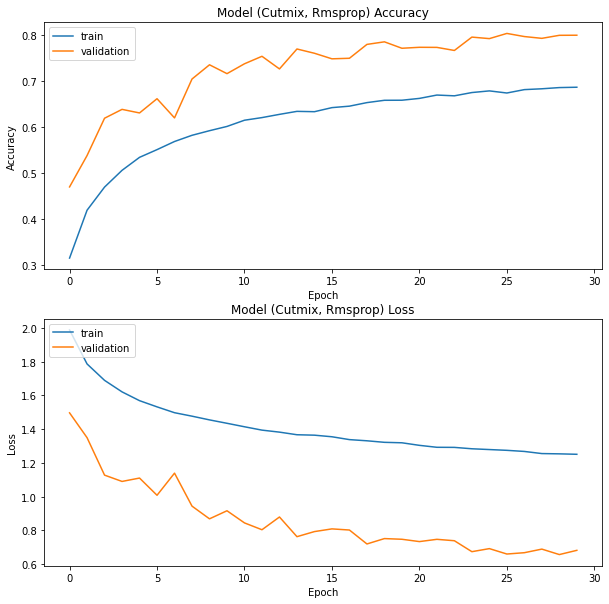

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(histMixRms.history['accuracy'])  
plt.plot(histMixRms.history['val_accuracy'])  
plt.title('Model (Cutmix, Rmsprop) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)   
plt.plot(histMixRms.history['loss'])  
plt.plot(histMixRms.history['val_loss']) 
plt.title('Model (Cutmix, Rmsprop) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

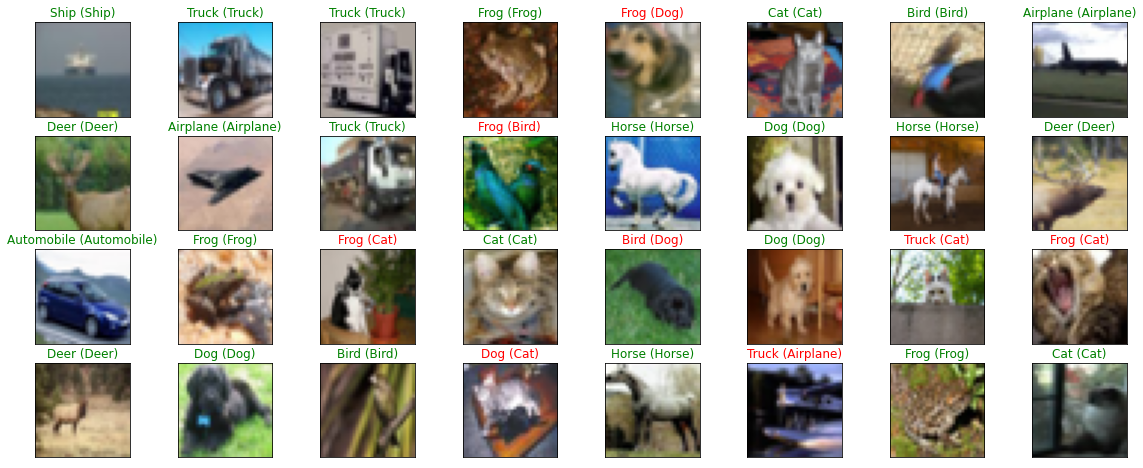

In [ ]:
# using the model to predict on test ds data

y_pred = model.predict(test_data_set)

# plot a random sample of test images, their predicted labels, and ground truth

fig = plt.figure(figsize = (20,8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size = 32, replace = False)):
  ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks = [])
  ax.imshow(np.squeeze(x_test[idx]))
  pred_idx = np.argmax(y_pred[idx])
  true_idx = np.argmax(y_test[idx])
  ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
               color=('green' if pred_idx == true_idx else 'red'))
  
 # Correct predict images : Green
 # Wrong predict images : Red 

**Cutmix : Optimizer - Adam/Rmsprop Graph (30 epochs)**

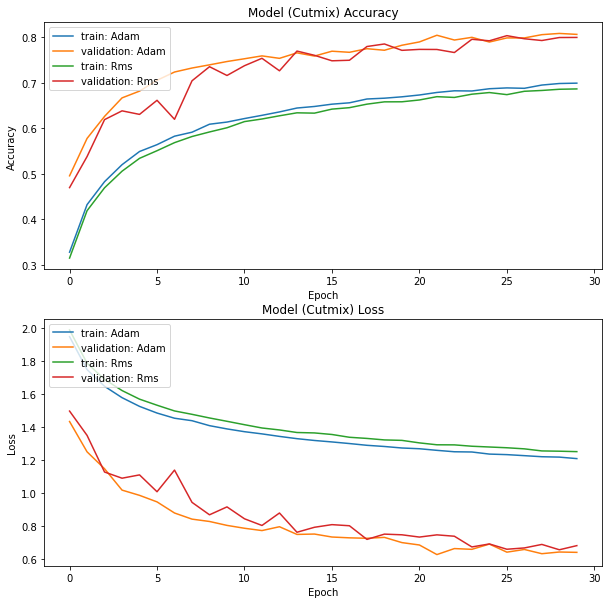

In [ ]:
#plotting the loss function and accuracy for different optimizer

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)  
plt.plot(histMixAdam.history['accuracy'])  
plt.plot(histMixAdam.history['val_accuracy'])  
plt.plot(histMixRms.history['accuracy'])  
plt.plot(histMixRms.history['val_accuracy'])  
plt.title('Model (Cutmix) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train: Adam', 'validation: Adam', 'train: Rms', 'validation: Rms'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)  
plt.plot(histMixAdam.history['loss'])  
plt.plot(histMixAdam.history['val_loss'])  
plt.plot(histMixRms.history['loss'])  
plt.plot(histMixRms.history['val_loss']) 
plt.title('Model (Cutmix) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train: Adam', 'validation: Adam', 'train: Rms', 'validation: Rms'], loc = 'upper left')  
plt.show()

Can see the Adam optimizer's performance better than RMSprop.

## 4.2) **Training the data without Cutmix(Adam/Rmsprop)**

**None Cutmix : Optimizer - Adam (30 epochs)**

In [ ]:
model.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer()

model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(1e-3), metrics = ["accuracy"]) 
histNoMixAdam = model.fit(train_normal, validation_data = test_data_set, epochs = 30, batch_size = 16)
# reflect the section 3.6 result (DNN with Batch size: 16 shows a better accuracy and loss score)
test_loss, test_accuracy = model.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("%f sec." % (process_time))

Epoch 1/30
1563/1563 [==============================] - 24s 15ms/step - loss: 1.6368 - accuracy: 0.4155 - val_loss: 1.3352 - val_accuracy: 0.5309
Epoch 2/30
1563/1563 [==============================] - 22s 14ms/step - loss: 1.2450 - accuracy: 0.5724 - val_loss: 1.0920 - val_accuracy: 0.6220
Epoch 3/30
1563/1563 [==============================] - 21s 14ms/step - loss: 1.0691 - accuracy: 0.6404 - val_loss: 0.9853 - val_accuracy: 0.6660
Epoch 4/30
1563/1563 [==============================] - 21s 14ms/step - loss: 0.9571 - accuracy: 0.6824 - val_loss: 0.9082 - val_accuracy: 0.6949
Epoch 5/30
1563/1563 [==============================] - 21s 14ms/step - loss: 0.8702 - accuracy: 0.7135 - val_loss: 0.8607 - val_accuracy: 0.7138
Epoch 6/30
1563/1563 [==============================] - 23s 15ms/step - loss: 0.8047 - accuracy: 0.7380 - val_loss: 0.8369 - val_accuracy: 0.7297
Epoch 7/30
1563/1563 [==============================] - 21s 13ms/step - loss: 0.7522 - accuracy: 0.7559 - val_loss: 0.8085 -

In [ ]:
print("Test accuracy (optimizer: Adam / Epochs: 30): {:.2f}%".format(test_accuracy * 100))
print("Test loss (optimizer: Adam / Epochs: 30) : {:.2f}%".format(test_loss * 100))

Test accuracy (optimizer: Adam / Epochs: 30): 77.78%
Test loss (optimizer: Adam / Epochs: 30) : 91.53%


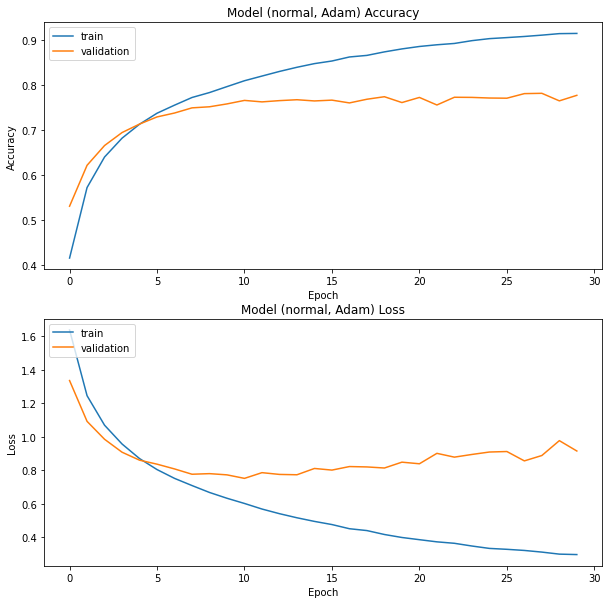

In [ ]:
# plotting model accuracy
plt.figure(1, figsize = (10, 10))  
plt.subplot(211)  
plt.plot(histNoMixAdam.history['accuracy'])  
plt.plot(histNoMixAdam.history['val_accuracy'])  
plt.title('Model (normal, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)  
plt.plot(histNoMixAdam.history['loss'])  
plt.plot(histNoMixAdam.history['val_loss'])  
plt.title('Model (normal, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()

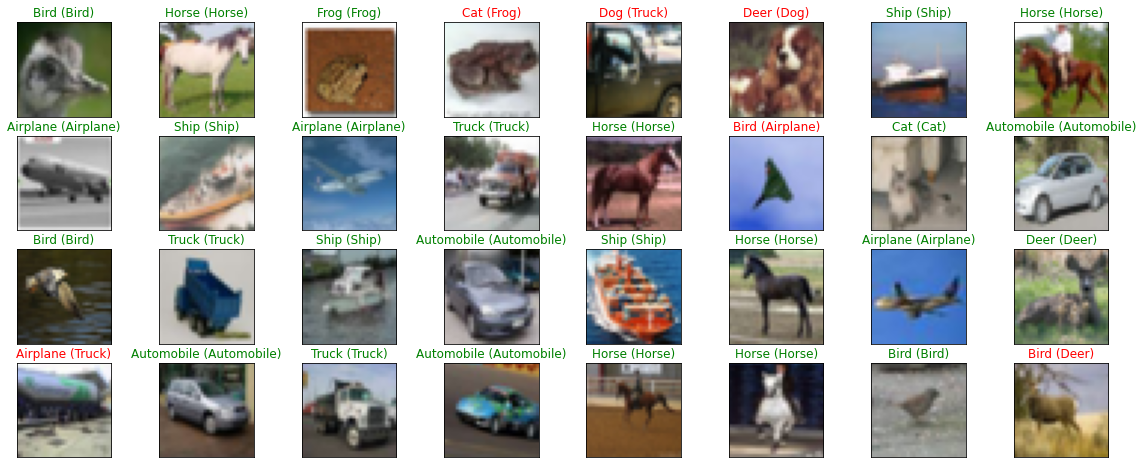

In [ ]:
# using the model to predict on test ds data

y_pred = model.predict(test_data_set)

# plot a random sample of test images, their predicted labels, and ground truth

fig = plt.figure(figsize = (20,8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size = 32, replace = False)):
  ax = fig.add_subplot(4, 8, i+1, xticks=[], yticks = [])
  ax.imshow(np.squeeze(x_test[idx]))
  pred_idx = np.argmax(y_pred[idx])
  true_idx = np.argmax(y_test[idx])
  ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
               color=('green' if pred_idx == true_idx else 'red'))
  
 # Correct predict images : Green
 # Wrong predict images : Red 

**None Cutmix : Optimizer - Rmsprop (30 epochs)**

In [ ]:
model.load_weights("initial_weights.h5")
# compile the model (Optimiser = rmsprop)

# check the start time
start_time = timeit.default_timer() 

model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.RMSprop(1e-3), metrics = ["accuracy"]) 
histNoMixRms = model.fit(train_normal, validation_data = test_data_set, epochs = 30, batch_size = 16)
# reflect the section 3.6 result (DNN with Batch size: 16 shows a better accuracy and loss score)
test_loss, test_accuracy = model.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("%f sec." % (process_time)) 

Epoch 1/30
1563/1563 [==============================] - 26s 16ms/step - loss: 1.6852 - accuracy: 0.4026 - val_loss: 1.4827 - val_accuracy: 0.4810
Epoch 2/30
1563/1563 [==============================] - 26s 16ms/step - loss: 1.3019 - accuracy: 0.5545 - val_loss: 1.2357 - val_accuracy: 0.5801
Epoch 3/30
1563/1563 [==============================] - 26s 16ms/step - loss: 1.1343 - accuracy: 0.6220 - val_loss: 1.1328 - val_accuracy: 0.6222
Epoch 4/30
1563/1563 [==============================] - 27s 17ms/step - loss: 1.0277 - accuracy: 0.6664 - val_loss: 1.0341 - val_accuracy: 0.6605
Epoch 5/30
1563/1563 [==============================] - 26s 17ms/step - loss: 0.9445 - accuracy: 0.6961 - val_loss: 1.0225 - val_accuracy: 0.6709
Epoch 6/30
1563/1563 [==============================] - 26s 17ms/step - loss: 0.8788 - accuracy: 0.7229 - val_loss: 0.9339 - val_accuracy: 0.7044
Epoch 7/30
1563/1563 [==============================] - 26s 17ms/step - loss: 0.8266 - accuracy: 0.7424 - val_loss: 0.9304 -

In [ ]:
print("Test accuracy (optimizer: Rmsprop / Epochs: 30): {:.2f}%".format(test_accuracy * 100))
print("Test loss (optimizer: Rmsprop / Epochs: 30) : {:.2f}%".format(test_loss * 100))

Test accuracy (optimizer: Rmsprop / Epochs: 30): 77.46%
Test loss (optimizer: Rmsprop / Epochs: 30) : 89.98%


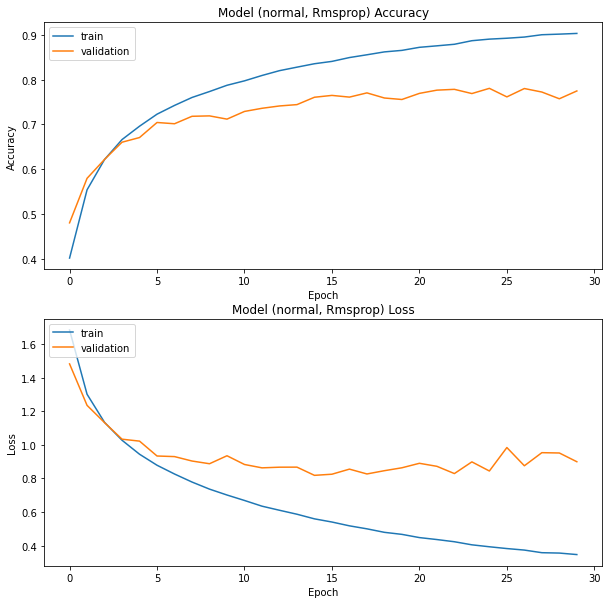

In [ ]:
# plotting model accuracy

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)   
plt.plot(histNoMixRms.history['accuracy'])  
plt.plot(histNoMixRms.history['val_accuracy'])  
plt.title('Model (normal, Rmsprop) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc='upper left')   

# plotting model loss 
plt.subplot(212)  
plt.plot(histNoMixRms.history['loss'])  
plt.plot(histNoMixRms.history['val_loss'])  
plt.title('Model (normal, Rmsprop) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()

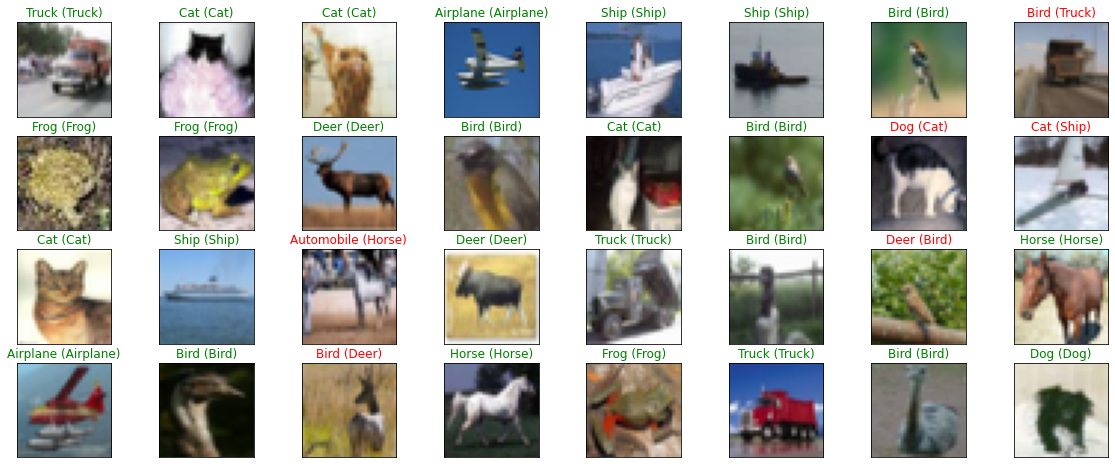

In [ ]:
# using the model to predict on test ds data

y_pred = model.predict(test_data_set)

# plot a random sample of test images, their predicted labels, and ground truth

fig = plt.figure(figsize = (20,8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size = 32, replace = False)):
  ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks = [])
  ax.imshow(np.squeeze(x_test[idx]))
  pred_idx = np.argmax(y_pred[idx])
  true_idx = np.argmax(y_test[idx])
  ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
               color=('green' if pred_idx == true_idx else 'red'))
  
 # Correct predict images : Green
 # Wrong predict images : Red 

**None Cutmix : Optimizer - Adam/Rmsprop Graph (30 epochs)**

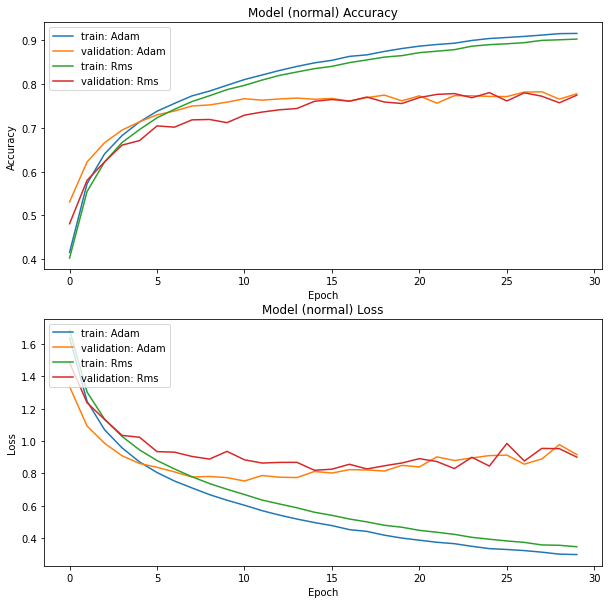

In [ ]:
#plotting the loss function and accuracy for different optimizer

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)  
plt.plot(histNoMixAdam.history['accuracy'])  
plt.plot(histNoMixAdam.history['val_accuracy'])  
plt.plot(histNoMixRms.history['accuracy'])  
plt.plot(histNoMixRms.history['val_accuracy'])  
plt.title('Model (normal) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train: Adam', 'validation: Adam', 'train: Rms', 'validation: Rms'], loc='upper left')   

# plotting model loss 
plt.subplot(212)  
plt.plot(histNoMixAdam.history['loss'])  
plt.plot(histNoMixAdam.history['val_loss'])  
plt.plot(histNoMixRms.history['loss'])  
plt.plot(histNoMixRms.history['val_loss'])  
plt.title('Model (normal) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train: Adam', 'validation: Adam', 'train: Rms', 'validation: Rms'], loc='upper left')  
plt.show()

Can see the Adam optimizer's performance better than RMSprop.

## 4.3) **Result - Compare Cutmix vs None Cutmix(Adam/Rmsprop)**

Comparing the two DNN models: 1. use Cutmix data augmentation 2. without Cutmix shows a big difference in especially the loss graph. 

* Cutmix:
> In the case of a model using cutmix data augmentation, the accuracy and loss score increase in a positive direction as the number of epochs increases. In other words, it was confirmed that the training was being conducted well without overfitting.

* Without Cutmix:
> Here, I predicted that overfitting has occurred, since the graph of the model without the cutmix augmentation that the Validation loss does not decrease over several epochs, but rather increases. Data augmentation, Early Stopping, Dropout, Batch Normalization should be used in this model.




**Compare the Cutmix vs no Cutmix (Adam/30 epochs)**

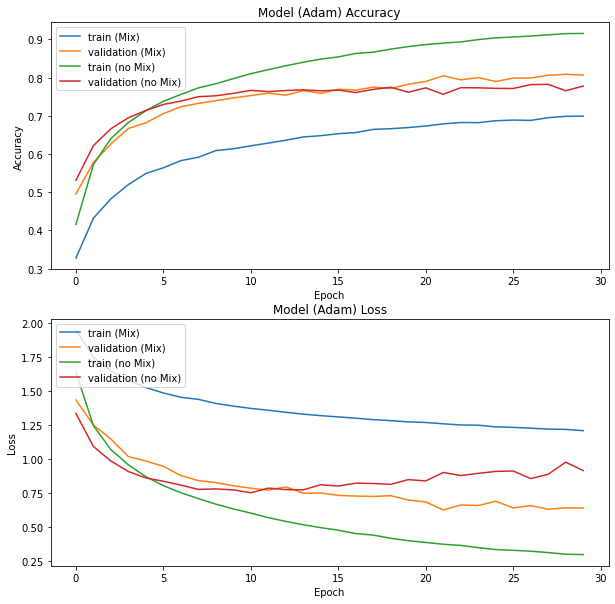

In [ ]:
# plotting model accuracy

plt.figure(1, figsize = (10, 10))  
plt.subplot(211) 
plt.plot(histMixAdam.history['accuracy'])  
plt.plot(histMixAdam.history['val_accuracy'])   
plt.plot(histNoMixAdam.history['accuracy'])  
plt.plot(histNoMixAdam.history['val_accuracy'])  
plt.title('Model (Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train (Mix)', 'validation (Mix)', 'train (no Mix)', 'validation (no Mix)'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)  
plt.plot(histMixAdam.history['loss'])  
plt.plot(histMixAdam.history['val_loss'])  
plt.plot(histNoMixAdam.history['loss'])  
plt.plot(histNoMixAdam.history['val_loss'])  
plt.title('Model (Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train (Mix)', 'validation (Mix)', 'train (no Mix)', 'validation (no Mix)'], loc='upper left')  
plt.show()

**Compare the Cutmix vs no Cutmix (Rmsprop/30 epochs)**

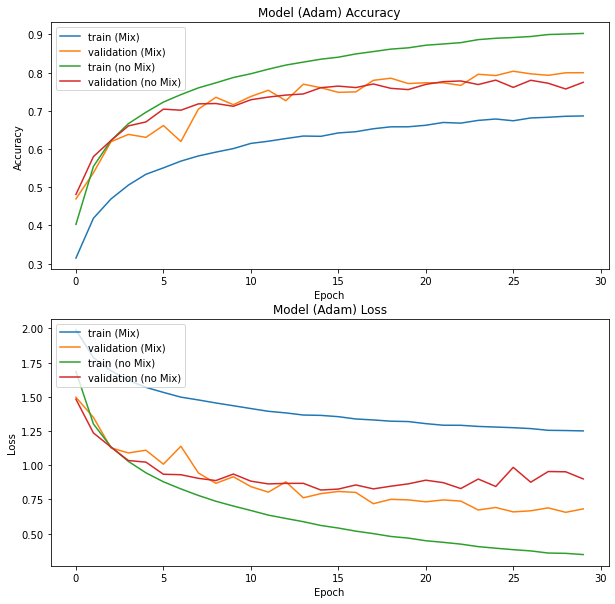

In [ ]:
# plotting model accuracy

plt.figure(1, figsize = (10, 10))  
plt.subplot(211) 
plt.plot(histMixRms.history['accuracy'])  
plt.plot(histMixRms.history['val_accuracy'])   
plt.plot(histNoMixRms.history['accuracy'])  
plt.plot(histNoMixRms.history['val_accuracy'])  
plt.title('Model (Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train (Mix)', 'validation (Mix)', 'train (no Mix)', 'validation (no Mix)'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)  
plt.plot(histMixRms.history['loss'])  
plt.plot(histMixRms.history['val_loss'])  
plt.plot(histNoMixRms.history['loss'])  
plt.plot(histNoMixRms.history['val_loss'])  
plt.title('Model (Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train (Mix)', 'validation (Mix)', 'train (no Mix)', 'validation (no Mix)'], loc='upper left')  
plt.show()

**Result plot**

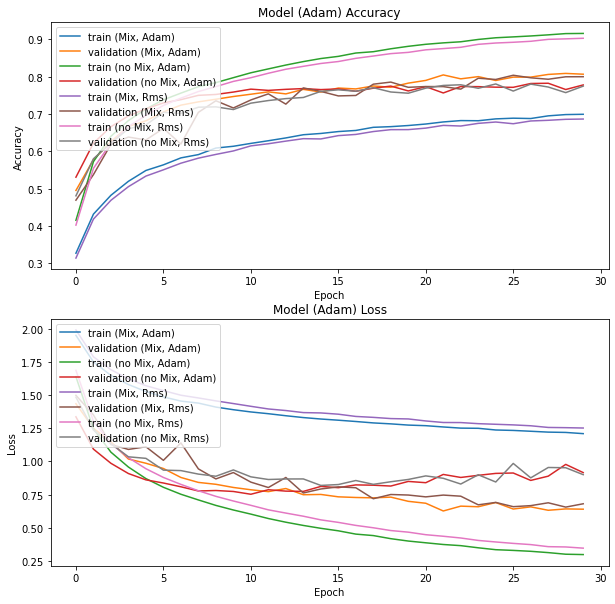

In [ ]:
# plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211) 
plt.plot(histMixAdam.history['accuracy'])  
plt.plot(histMixAdam.history['val_accuracy'])   
plt.plot(histNoMixAdam.history['accuracy'])  
plt.plot(histNoMixAdam.history['val_accuracy']) 
plt.plot(histMixRms.history['accuracy'])  
plt.plot(histMixRms.history['val_accuracy'])   
plt.plot(histNoMixRms.history['accuracy'])  
plt.plot(histNoMixRms.history['val_accuracy'])  
plt.title('Model (Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train (Mix, Adam)', 'validation (Mix, Adam)', 'train (no Mix, Adam)', 'validation (no Mix, Adam)',
            'train (Mix, Rms)', 'validation (Mix, Rms)', 'train (no Mix, Rms)', 'validation (no Mix, Rms)'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)  
plt.plot(histMixAdam.history['loss'])  
plt.plot(histMixAdam.history['val_loss'])  
plt.plot(histNoMixAdam.history['loss'])  
plt.plot(histNoMixAdam.history['val_loss'])  
plt.plot(histMixRms.history['loss'])  
plt.plot(histMixRms.history['val_loss'])  
plt.plot(histNoMixRms.history['loss'])  
plt.plot(histNoMixRms.history['val_loss'])  
plt.title('Model (Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train (Mix, Adam)', 'validation (Mix, Adam)', 'train (no Mix, Adam)', 'validation (no Mix, Adam)',
            'train (Mix, Rms)', 'validation (Mix, Rms)', 'train (no Mix, Rms)', 'validation (no Mix, Rms)'], loc='upper left')  
plt.show()

DNN Setting  | Accuracy Score | Loss score
-------------------|--------------------|------------------
Cutmix (Adam / Epochs: 30) ★      | 80.65% | 63.98%
Cutmix (Rmsprop / Epochs: 30)       | 79.98% | 68.06%
None Cutmix (Adam / Epochs: 30)       | 77.78% | 91.53%
None Cutmix (Rmsprop / Epochs: 30)       | 77.46% | 89.98%

The case of 3 hidden layers of DNN with Adam optimizer (Cutmix) shows a better accuracy and loss score. Therefore, included **Adam** optimizer in the final version of the DNN structure. In addition, especially when using **cutmix**, the accuracy score slightly increased(2.87%) and the loss score decreased(27.55%) and preventing the overfitting. So, I also selected to use cutmix data augmentation for the final DNN model.

> ***Case reflected in the final DNN structure:Activation Function (Adam)***

> ***Case reflected in the final DNN structure: Used Cutmix data augmentation***

# 5) **Compare the result of several hyperparameters**

DNN Setting  | Accuracy Score | Loss score
-------------------|--------------------|------------------
2 Hidden layer (filters: 64, 128, 128)      | 75.88% | 81.09%
3 Hidden layer (filters: 64, 128, 128, 128) ★       | 76.42% | 73.79%
3 Hidden layer (filters: 32, 64, 128, 128)       | 75.55% | 76.18%
3 Hidden layer (filters: 32, 64, 64, 128)       | 74.06% | 81.14%
4 Hidden layer (filters: 64, 128, 128, 128, 128)       |  76.41% | 75.71%
Dropout = 0.2       | 76.42% | 73.79%
Dropout = 0.1     | 77.52% | 71.70%
Dropout = 0.05 ★     | 78.83% | 66.73%
kernel_size = 2       | 76.67% | 76.05%
kernel_size = 3 ★     | 79.41%% | 64.89%
kernel_size = 4     | 79.00% | 66.75%
Batch_size = 64     | 79.70% | 64.96%
Batch_size = 32     | 79.16% | 64.82% 
Batch_size = 16 ★   | 79.16% | 65.02% 
With Max Pooling           | 79.40% | 67.09%
Without Max Pooling       | 74.75% | 141.18%
With Average Pooling ★   | 80.50% | 63.66%
Act func: Tanh           | 69.87% | 96.90%
Act func: Relu        | 79.79% | 65.46%
Act func: Leaky Relu★   | 81.91% | 59.43%
Learning Rate = 1e-2      | 23.19% | 938.23%
Learning Rate = 1e-3 ★   | 80.89% | 62.90%
Learning Rate = 1e-4       | 65.09% | 108.74%
Cutmix (Adam / Epochs: 30) ★      | 80.65% | 63.98%
Cutmix (Rmsprop / Epochs: 30)       | 79.98% | 68.06%
None Cutmix (Adam / Epochs: 30)       | 77.78% | 91.53%
None Cutmix (Rmsprop / Epochs: 30)       | 77.46% | 89.98%

***Case reflected in the final DNN structure (Hyperparameters):***

> * 3 Hidden layer (filters: 64, 128, 128, 128)
> * Dropout: 0.05
> * Kernel Size: 3
> * Batch Size: 16
> * With Average Pooling
> * Act Func: Leack Relu
> * Learning Rate:1e-3
> * Optimizer: Adam 
> * Use Cutmix


# 6) **Result: Final Deep Neural Network model & Output (200 epochs)**

**This is the final version of the DNN that I implemented for this assignment.**

Train the final version of the DNN model through a bigger number of epochs to get better accuracy and loss.

In [ ]:
# image dimensions
input_shape = (32, 32, 3)

# used hyperparemeters
# section 4.5
kernel_size = 3
# section 4.6
batch_size = 16
# section 4.7
pool_size = 2
kernel_regularizer = regularizers.l2(0.01)
# section 4.4
dropout = 0.05
# section 4.9
learining_rate = 1e-3

In [ ]:
# Define the model

input_size = x_train.shape[1:]

# model is a 3-layer CNN with ReLU and dropout after each layer
model = Sequential()

# Input layer
model.add(Convolution2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1), 
                        input_shape = x_train.shape[1:]))
model.add(AveragePooling2D(pool_size = 2))
model.add(Dropout(dropout))

# 1st Hidden layer 
model.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
model.add(AveragePooling2D(pool_size = 2))
model.add(Dropout(dropout))
# 2nd Hidden layer 
model.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
model.add(AveragePooling2D(pool_size = 2))
model.add(Dropout(dropout))
# 3rd Hidden layer 
model.add(Convolution2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.1)))
model.add(AveragePooling2D(pool_size = 2))
model.add(Dropout(dropout))

model.add(Flatten())
model.add(Dropout(dropout))
#cnn.add(Dense(hidden_units,activation='relu'))
#cnn.add(Dropout(dropout))

# Output layer
model.add(Dense(10, activation = 'softmax', kernel_regularizer = kernel_regularizer))

model.summary()

# The input image passes through the convolution layer, and the max-pooling layer and removes spatial information.
# The result is become to flatten, and then add two layers that are fully connected rather than locally connected.
# In the meantime, a dropout layer is added and minimizes over-fitting.
# This network uses only a much smaller number of parameters than MLP (MLP: 3,590,642 CNN: 528,054), but its ability to classify images is stronger.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 64)       0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 average_pooling2d_1 (Averag  (None, 8, 8, 128)        0         
 ePooling2D)                                                     
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0

In [ ]:
model.save_weights("initial_weights.h5")

In [ ]:
model.load_weights("initial_weights.h5")
# compile the model (Optimiser = adam)

# check the start time
start_time = timeit.default_timer() 

model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(1e-3), metrics = ["accuracy"]) 
histMix = model.fit(train_data_cutMix, validation_data = test_data_set, epochs = 200, batch_size = 16)
# reflect the section 4.6 result (DNN with Batch size: 16 shows a better accuracy and loss score)

test_loss, test_accuracy = model.evaluate(test_data_set)

# check the end time
terminate_time = timeit.default_timer()

process_time = terminate_time - start_time

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("%f sec." % (process_time)) 

Epoch 1/200
1563/1563 [==============================] - 55s 26ms/step - loss: 1.9464 - accuracy: 0.3294 - val_loss: 1.4578 - val_accuracy: 0.4915
Epoch 2/200
1563/1563 [==============================] - 38s 24ms/step - loss: 1.7520 - accuracy: 0.4301 - val_loss: 1.2578 - val_accuracy: 0.5658
Epoch 3/200
1563/1563 [==============================] - 38s 24ms/step - loss: 1.6508 - accuracy: 0.4847 - val_loss: 1.1276 - val_accuracy: 0.6171
Epoch 4/200
1563/1563 [==============================] - 37s 24ms/step - loss: 1.5825 - accuracy: 0.5172 - val_loss: 1.0776 - val_accuracy: 0.6613
Epoch 5/200
1563/1563 [==============================] - 38s 24ms/step - loss: 1.5320 - accuracy: 0.5422 - val_loss: 0.9889 - val_accuracy: 0.6749
Epoch 6/200
1563/1563 [==============================] - 37s 24ms/step - loss: 1.4923 - accuracy: 0.5646 - val_loss: 0.9512 - val_accuracy: 0.7114
Epoch 7/200
1563/1563 [==============================] - 37s 24ms/step - loss: 1.4602 - accuracy: 0.5782 - val_loss: 0

In [ ]:
print("Test accuracy (optimizer: Adam / Epochs: 200): {:.2f}%".format(test_accuracy * 100))
print("Test loss (optimizer: Adam / Epochs: 200) : {:.2f}%".format(test_loss * 100))

Test accuracy (optimizer: Adam / Epochs: 200): 84.34%
Test loss (optimizer: Adam / Epochs: 200) : 52.43%


**Graph of the final DNN acc/loss**

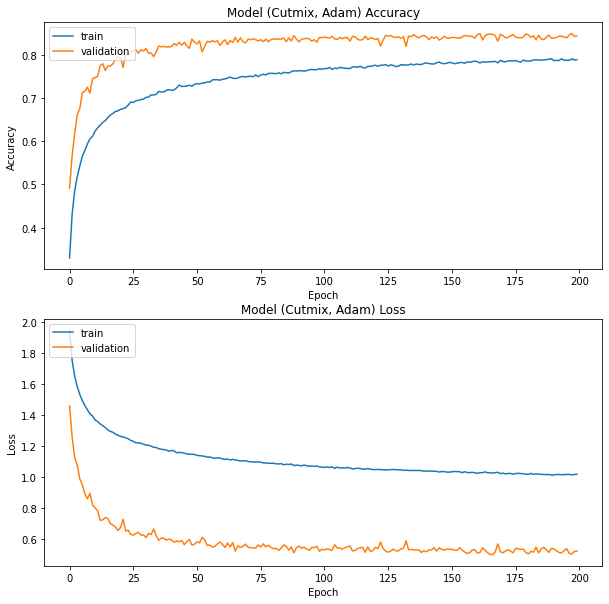

In [ ]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)  
plt.plot(histMix.history['accuracy'])  
plt.plot(histMix.history['val_accuracy'])  
plt.title('Model (Cutmix, Adam) Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')   

# plotting model loss 
plt.subplot(212)  
plt.plot(histMix.history['loss'])  
plt.plot(histMix.history['val_loss'])  
plt.title('Model (Cutmix, Adam) Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc = 'upper left')  
plt.show()

**Confirm the predicted images classified by trained final DNN**

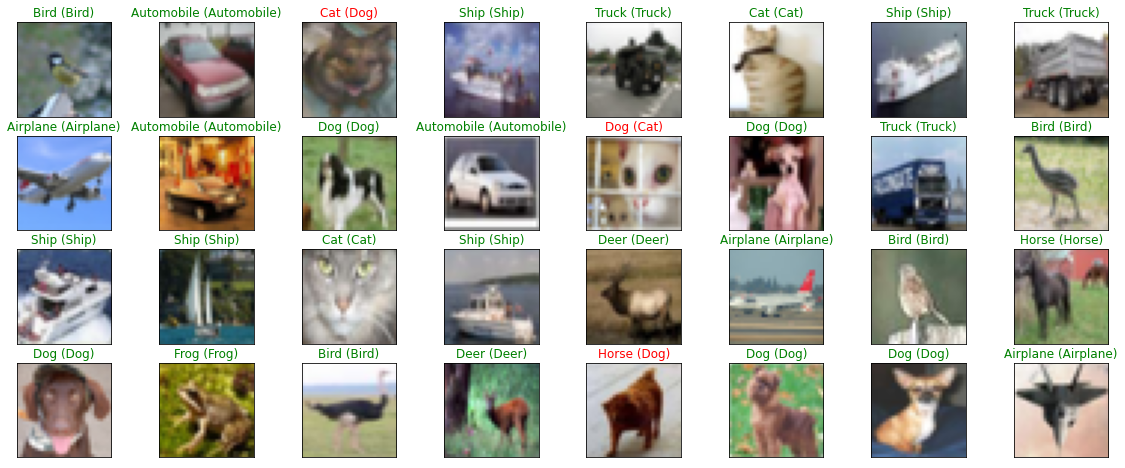

In [ ]:
# using the model to predict on test ds data

y_pred = model.predict(test_data_set)

# plot a random sample of test images, their predicted labels, and ground truth

fig = plt.figure(figsize = (20,8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size = 32, replace = False)):
  ax = fig.add_subplot(4, 8, i+1, xticks = [], yticks = [])
  ax.imshow(np.squeeze(x_test[idx]))
  pred_idx = np.argmax(y_pred[idx])
  true_idx = np.argmax(y_test[idx])
  ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
               color=('green' if pred_idx == true_idx else 'red'))
  
 # Correct predict images : Green
 # Wrong predict images : Red 

# 7) ***Conclusion***

DNN Setting  | Accuracy Score | Loss score
-------------------|--------------------|------------------
Cutmix (Adam / Epochs: 30) ★      | 80.65% | 63.98%
None Cutmix (Adam / Epochs: 30)       | 77.78% | 91.53%
Cutmix (Rmsprop / Epochs: 30)       | 79.98% | 68.06%
None Cutmix (Rmsprop / Epochs: 30)       | 77.46% | 89.98%

In this study, I trained the final version (section 5) of the DNN model for 200 epochs. The followings are the result of DNN:

> **Test accuracy (optimizer: Adam / Epochs: 200): 84.34%**

> **Test loss (optimizer: Adam / Epochs: 200) : 52.43%**

I hope to train the data with a larger number of epochs, however, the google colab is usually stopping with larger than 200 epochs number.

In my experiment, the model with CutMix achieves a bit better accuracy score and a much lower loss score on the CIFAR-10 dataset compared to the model that did not use the cutmix augmentation.


